# Section 20.6.5 of Machine Learning Bootcamp : Capstone Step 5, Data Wrangling and EDA

Here I will focus on my chosen dataset for the capstone project, using Exploratory Data Analysis methods and Data Wrangling techniques to prepare and better undersnat the data. The prior step of the capstone had me find a similar project, but there it appears all the data was already wrangled and cleaned (for the most part) by whoever is responsible for managing the city's data. Also the writers of the paper seem to have received quite a bit of guidance about how to create the features used in their model, so here I will have to determine all that myself.

# Step 1: imports, option sets and data loading

In [392]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

from numpy.lib.recfunctions import drop_fields
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from sklearn.neighbors import BallTree # for finding nearest geographical neighbors

pd.options.display.max_columns = 999

# sets up the current date for later calculations
CURRENT_DATE = dt(2024,12,31)


## CSV Dataset: Idle wells at risk of fees or penalties in California
<p>To recap, in 2021, new legislation was passed in California that escalates the fines oil & gas operators must pay if they have not tested their idle wells according to the law. There is now a dramatic escalation of fees based on a schedule of the age of the well, and the duration of idleness.<br></p>

<p><b>Problem statement:</b> Given that not all the data is available to accurately determine the specific status of a well, I think we can using machine learning to assess the companies exposure to the risk: i.e. have they been addressing their idle well burden by plugging & abandoning their idle well fleets, or are they "kicking the can down the road", and postponing until max pain arrives.<br></p>

<p><b>Hypothesis:</b> I think the larger companies (Chevron, Aera, SPR, CRC) are likely addressing their own idle well situations in a way to avoid onerous fees, and potentially damaging optics of not following the law. However, I suspect there a large number of smaller privately owned companies that have not kept up with their liabilities, and either don't have the cash flow to take care of it, or are hoping to fly under the radar for a bit longer.</p>

<p><b>Data set:</b> the state publishes its view of the list of all wells in the state (241,912 data points, each of which represents a physical well), with currently known status and original drill (SPUD) date, so we know the age of the well, and the state's view of the status, which they have likely calculated based on the monthly production reports the operators are legally bound to send them. I have heard annecdotally it can take the state up to 2 years to update the well status, so there's some room here for machine learning to predict a trend by operator.</p>

**Files:**
    - master well listing: downloaded from state's website (filesize 55MB): <a href='https://gis.conservation.ca.gov/portal/home/item.html?id=0d30c4d9ac8f4f84a53a145e7d68eb6b'>linked here</a> and added to my git repo here: <a href='source_data/CALGEM AllWells_20241113.csv'>CALGEM AllWells_20241113.csv</a>
    - production/injection data files: use this link and then search for "BAK" files to get the database backups by year from 2019-current. https://wellstar-public.conservation.ca.gov/General/PublicDownloads/Index
    - older database files are available here: https://filerequest.conservation.ca.gov/?q=pre-2018_data_format

In [337]:
# joined 2 datasets together already in Excel, the all well list, and the idle list

# load candidate data file 1 and take a peek
# will take some work to get the data loaded with proper datatypes, and dates set correctly
# I'll use the API as the index as it should be unique, and is the well's identifier if any other data gets joined later.
well_list_datatypes = {
    'API':str,
    'LeaseName':str,
    'WellNumber':str,
    'WellDesign':str,
    'WellStatus':str,
    'WellType':str,
    'WellTypeLa':str,
    'OperatorCo':str,
    'OperatorNa':str,
    'FieldName':str,
    'AreaName':str,
    'Place':str,
    'District':str,
    'CountyName':str,
    'Section':int,
    'Township':str,
    'Range':str,
    'BaseMeridi':str,
    'Latitude':np.float64,
    'Longitude':np.float64,
    'GISSource':str,
    'isConfiden':str,
    'isDirectio':str,
    'inHPZ':str,
    'WellSymbol':str,
    'YearsIdle':np.float32,
    'IsLTIW':str,
    'UnsatAbandon':str
}

parse_date_list = ['SpudDate', 'IdleDate']
# CALGEM AllWells_20241113.csv
# AllWells_20241226.csv
well_list_df = pd.read_csv('source_data/CALGEM AllWells_20241113.csv', dtype=well_list_datatypes, parse_dates=parse_date_list, date_format='%m/%d/%Y', skipinitialspace=True)
well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,NaN,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN


## SQL Data: Loading well numbers and last production dates for merging

In [338]:
# After inserting a new well/year row into "wells". use "mycursor.lastrowid" or "connection.insert_id()" to get the Last inserted ID for the monthly_well_volumes table
lastprod_df = pd.DataFrame()
pickle_file_name = "last_prod_date.pkl"

if os.path.exists(pickle_file_name) :
    print("Reading existing mv pickle...")
    lastprod_df = pd.read_pickle(pickle_file_name)
else:
    print("Reading last prod data from SQL...")
    mysql_dbname = "doggr"
    mysql_well_tablename ='wells_test'
    mysql_mv_tablename = 'monthly_well_volume_test'

    cfg = configparser.ConfigParser()
    cfg.read('mysql_creds.ini')
    mysql_cfg = cfg['mysql']

    mysql_user = mysql_cfg['mysql_user']
    mysql_password = mysql_cfg['mysql_password']
    mysql_host = mysql_cfg['mysql_host']

    # Connect to the mysql server to load the data
    # SQLAlchemy uses a database driver to connect, in this case I'll use mysql-connector-python
    conn_str = f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_dbname}"
    engine = create_engine(conn_str, echo=True)

    # This finds the last production or injection by API number
    sql_query = '''
    WITH volumes AS (
        SELECT
            api_no,
            prod_inj_date,
            COALESCE(oil_prod_vol_bbl,0)+COALESCE(gas_prod_vol_mcf,0)+COALESCE(water_prod_vol_bbl,0)+COALESCE(gas_inj_vol_mcf,0)+COALESCE(water_inj_vol_bbl,0)+COALESCE(stm_inj_vol_bbl,0) as volume
        FROM doggr.monthly_well_volume
        WHERE prod_inj_date is not null
        AND (COALESCE(oil_prod_vol_bbl,0)+COALESCE(gas_prod_vol_mcf,0)+COALESCE(water_prod_vol_bbl,0)+COALESCE(gas_inj_vol_mcf,0)+COALESCE(water_inj_vol_bbl,0)+COALESCE(stm_inj_vol_bbl,0)) > 0
    )
    SELECT
        left(api_no,10) as api_10,
        max(case when volume > 0 or volume is not null then prod_inj_date else null end) as last_date
    FROM
        volumes
    GROUP BY left(api_no,10)
    ORDER BY left(api_no,10)
    '''

    with engine.begin() as conn:
        result = conn.execute(text(sql_query))
        # Get the well_id list by api_key
        lastprod_df = pd.DataFrame(result.fetchall(), columns=result.keys())

    # MYSQL provides the Date in format '%Y-%m-%d', maybe it's an ISO default, not sure
    lastprod_df['last_date'] = pd.to_datetime(lastprod_df['last_date'], format='%Y-%m-%d').astype('datetime64[ns]')

    # save it to a local file, the SQL takes ~ 5 minutes to run
    lastprod_df.to_pickle(pickle_file_name)

lastprod_df

Reading existing mv pickle...


,api_10,last_date
0,0400100001,2019-12-31
1,0400120004,2022-01-31
2,0400120005,1989-12-31
3,0400120008,2014-06-30
4,0400120009,2020-11-30
...,...,...
153305,0428321583,1992-08-31
153306,0428321584,1990-07-31
153307,0428321585,1992-08-31
153308,0428321586,1992-08-31


In [339]:
lastprod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153310 entries, 0 to 153309
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   api_10     153310 non-null  object        
 1   last_date  153310 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 2.3+ MB


## Basic Imputation - 1 well missing FieldName, which is really important later, so fixing it here

In [340]:
# looks like 1 null FieldName, replace with the generic 'Any Field' designation
well_list_df.fillna({'FieldName':'Any Field'}, inplace=True)

## Basic feature engineering to get some helper columns set up to assist with EDA
 Year columns for the date columns
 Naive Last Production year, which will be Idle Year - Years Idle - 2 for rows where that's populated
 (naive because there's a complexity that I'll deal with later in the Imputation section)

In [341]:
well_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241912 entries, 0 to 241911
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   API           241912 non-null  object        
 1   LeaseName     241912 non-null  object        
 2   WellNumber    241567 non-null  object        
 3   WellDesign    241779 non-null  object        
 4   WellStatus    241912 non-null  object        
 5   WellType      241912 non-null  object        
 6   WellTypeLa    241912 non-null  object        
 7   OperatorCo    241912 non-null  object        
 8   OperatorNa    241912 non-null  object        
 9   FieldName     241912 non-null  object        
 10  AreaName      240458 non-null  object        
 11  Place         241895 non-null  object        
 12  District      241912 non-null  object        
 13  CountyName    241912 non-null  object        
 14  Section       241912 non-null  int64         
 15  Township      241

In [342]:
well_list_df.describe()

,Section,Latitude,Longitude,SpudDate,IdleDate,YearsIdle
count,241912.000000,241912.000000,241912.000000,80840,29910,29910.000000
mean,18.972134,35.314957,-119.462110,1990-01-06 00:31:03.948540416,2007-04-30 06:49:19.438314752,16.671970
min,1.000000,32.537811,-124.363670,1801-01-01 00:00:00,1900-01-01 00:00:00,0.000000
25%,9.000000,35.077979,-119.735008,1972-02-09 18:00:00,2005-10-01 00:00:00,3.250000
50%,19.000000,35.366459,-119.566372,1997-10-16 00:00:00,2016-06-01 00:00:00,7.583333
75%,29.000000,35.485517,-118.990685,2012-06-14 00:00:00,2020-10-01 00:00:00,18.250000
max,36.000000,41.812958,-114.572904,2026-03-26 00:00:00,2024-01-01 00:00:00,124.000000
std,11.030148,1.003615,0.851529,NaN,NaN,24.304653


In [343]:
# What percentage of the 39k idle wells, how many are missing the SPUD date?
well_list_df.isna().sum()

API                  0
LeaseName            0
WellNumber         345
WellDesign         133
WellStatus           0
WellType             0
WellTypeLa           0
OperatorCo           0
OperatorNa           0
FieldName            0
AreaName          1454
Place               17
District             0
CountyName           0
Section              0
Township             0
Range                0
BaseMeridi           0
Latitude             0
Longitude            0
GISSource            0
isConfiden           0
isDirectio           0
SpudDate        161072
inHPZ                0
WellSymbol           0
IdleDate        212002
YearsIdle       212002
IsLTIW          212002
UnsatAbandon    212002
dtype: int64

In [344]:
# create a flag to exclude the fields that are already fully abandoned; I'll be mostly ignoring these later
well_list_df['FieldAbd'] = [True if "(ABD)" in str(x) else False for x in well_list_df['FieldName']]

# Check : Row 50 should be False (not ABD) and Row 51 should be True (is ABD)
well_list_df.iloc[50:52]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd
50,0402100015,ROCO-Afton Community,66-34,ROCO-Afton Community 66-34,Plugged,DH,Dry Hole,A4550,Arco Western Energy Co.,Afton Gas,Main,Glenn County,Northern,Glenn,34,19N,01W,MD,39.454037,-121.954735,hud,N,N,1962-06-10,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,False
51,0402120107,Glassgow,10-Jan,Glassgow 1-10,Plugged,DG,Dry Gas,S3100,Shell Western E&P Inc.,"Afton, South, Gas (ABD)",Any Area,Glenn County,Northern,Glenn,10,18N,01W,MD,39.424908,-121.965179,hud,N,Y,1977-05-31,Potentially HPZ,PluggedDG,NaT,NaN,NaN,NaN,True


In [345]:
# add year column, it should speed up calculations and won't affect accuracy of the results
# note: could use .dt.year.astype('Int64') to return an integer, and use 'Int64' instead of
#   just int because basic int can't handle NaN but the median function below will 
#   return a float anyway, so just leave it as a float
# 
well_list_df['SpudYear'] = well_list_df['SpudDate'].dt.year
well_list_df['IdleYear'] = well_list_df['IdleDate'].dt.year
#well_list_df.drop(columns=['api_10_x','last_date_x','api_10_y','last_date_y'], inplace=True)
#well_list_df['LastProdYear'] = well_list_df['IdleYear'] - well_list_df['YearsIdle'] - 2


In [346]:
well_list_df = pd.merge(well_list_df, lastprod_df, how='left', left_on='API', right_on='api_10')
well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,NaT
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,NaT
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,NaT


In [347]:
# for long ago dates, set it to the 1/1/1977; it's irrelevant for our purposes if it's before that
well_list_df.loc[(well_list_df['last_date'].isna()) & (well_list_df['WellStatus'] == 'Idle') & (well_list_df['IdleYear'] < 1977), 'last_date'] = dt(1977,1,1).date()
well_list_df

C:\Users\dan\AppData\Local\Temp\ipykernel_31136\3779335708.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1977-01-01' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  well_list_df.loc[(well_list_df['last_date'].isna()) & (well_list_df['WellStatus'] == 'Idle') & (well_list_df['IdleYear'] < 1977), 'last_date'] = dt(1977,1,1).date()


,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31 00:00:00
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31 00:00:00
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31 00:00:00
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28 00:00:00
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,NaT
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31 00:00:00
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,NaT


In [348]:
# subtract 2 years from the idle date to see when last production would have been
well_list_df.loc[(well_list_df['last_date'].isna()) & (well_list_df['WellStatus'] == 'Idle' ), 'last_date'] = well_list_df['IdleDate'] - pd.DateOffset(years=2)
well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31 00:00:00
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31 00:00:00
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31 00:00:00
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28 00:00:00
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,NaT
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31 00:00:00
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,NaT


In [349]:
# finally, set any additional NULL in last_date to current for Active wells, and 1977 for Plugged wells
well_list_df.loc[(well_list_df['last_date'].isna()) & (well_list_df['WellStatus'] == 'Active' ), 'last_date'] = CURRENT_DATE.date()
well_list_df.loc[(well_list_df['last_date'].isna()) & (well_list_df['WellStatus'] == 'Plugged' ), 'last_date'] = dt(1977,1,1).date()
well_list_df.loc[(well_list_df['last_date'].isna()), 'last_date'] = dt(1977,1,1).date()

well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31 00:00:00
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31 00:00:00
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31 00:00:00
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28 00:00:00
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,1977-01-01
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31 00:00:00
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,1977-01-01


In [350]:
well_list_df['last_date'] = well_list_df['last_date'].astype('datetime64[ns]')

In [351]:
well_list_df['LastProdYear'] = well_list_df['last_date'].dt.year
well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28,1982
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,1977-01-01,1977
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31,1985
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,1977-01-01,1977


In [352]:
# ensure we don't have any LastProdYears prior to around 1875 which is the year of the discovery of the Pico Canyon oil field in Los Angeles
# (earliest well drilled around oil seeps in 1866, but wasn't really commercial production) 
well_list_df[well_list_df['LastProdYear'] < 1980].value_counts('LastProdYear').sort_index()

LastProdYear
1975       32
1976      344
1977    86033
1978     1072
1979      910
Name: count, dtype: int64

In [353]:
# So what's happening is the regulators have likely just put a date of 1900/1/1 (which is the 0 date in Excel) into some of the IdleDate fields, so subtracting Years Idle from that, gives us these wierd LastProdYears
# Let's check a calculated Idle Date with provided Idle Date... public database production records started with the state in 1977, so we'll set LastProdYear to 1977 for those just to have something a long time ago, but not pre-industrial age
# I don't know the regulators are doing any manual records searches for their listed Idle Dates, maybe this will reveal something
well_list_df['CalcIdleDate'] = None
well_list_df.loc[(~well_list_df['last_date'].isnull()) & (well_list_df['last_date'] < CURRENT_DATE) & (~well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])), 'CalcIdleDate'] =  well_list_df['last_date'] + pd.DateOffset(years=2)
well_list_df['CalcIdleDate'] = well_list_df['CalcIdleDate'].astype('datetime64[ns]')

# some wells will have stopped volume recordings less than 2 years ago - if that's the case, they're not technically "IDLE" yet (as far as this model goes; there is some actual nuance, but not important to start)
well_list_df['CalcYearsIdle'] = round((CURRENT_DATE - well_list_df['CalcIdleDate']).dt.days/365.25, 2)
well_list_df.loc[well_list_df['CalcYearsIdle'] <= 0, 'CalcIdleDate']  = None
well_list_df.loc[well_list_df['CalcYearsIdle'] <= 0, 'CalcYearsIdle'] = 0

# also derive the year for simpler comparisons
well_list_df['CalcIdleYear'] = well_list_df['CalcIdleDate'].dt.year
# For wells without an Idle year, if it's been P&A'ed, it's 0, otherwise just put it in the future for now
well_list_df['CalcIdleYear'] = well_list_df[well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])]['CalcIdleYear'].fillna(0)
well_list_df['CalcIdleYear'] = well_list_df['CalcIdleYear'].fillna(2040)

# is the calculated idle year the same as the provided one?
well_list_df['IsIdleYearSame'] = well_list_df['IdleYear'].eq(well_list_df['CalcIdleYear'])
well_list_df.loc[(well_list_df['IdleYear'].isna()) & (well_list_df['CalcIdleYear'].isna()), 'IsIdleYearSame'] = False

#well_list_df['LastProdYear'] = well_list_df[well_list_df['LastProdYear']

In [354]:
well_list_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.00,2040.0,False
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013,2015-07-31,9.42,2040.0,False
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013,2015-07-31,9.42,2040.0,False
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009,2011-05-31,13.59,2040.0,False
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023,NaT,0.00,2040.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28,1982,NaT,NaN,0.0,False
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,1977-01-01,1977,NaT,NaN,0.0,False
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31,1985,NaT,NaN,0.0,False
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,1977-01-01,1977,NaT,NaN,0.0,False


In [355]:
well_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241912 entries, 0 to 241911
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   API             241912 non-null  object        
 1   LeaseName       241912 non-null  object        
 2   WellNumber      241567 non-null  object        
 3   WellDesign      241779 non-null  object        
 4   WellStatus      241912 non-null  object        
 5   WellType        241912 non-null  object        
 6   WellTypeLa      241912 non-null  object        
 7   OperatorCo      241912 non-null  object        
 8   OperatorNa      241912 non-null  object        
 9   FieldName       241912 non-null  object        
 10  AreaName        240458 non-null  object        
 11  Place           241895 non-null  object        
 12  District        241912 non-null  object        
 13  CountyName      241912 non-null  object        
 14  Section         241912 non-null  int

In [356]:
well_list_df['IsIdleYearSame'].value_counts()

IsIdleYearSame
False    241912
Name: count, dtype: int64

In [357]:
well_list_df[well_list_df['IsIdleYearSame'] == False]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.00,2040.0,False
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013,2015-07-31,9.42,2040.0,False
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013,2015-07-31,9.42,2040.0,False
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009,2011-05-31,13.59,2040.0,False
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023,NaT,0.00,2040.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241907,0411320572,Knaggs-Wallace,5,Knaggs-Wallace 5,Plugged,DG,Dry Gas,P0325,Pacific Inland Operating Corporation,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,12,11N,01E,MD,38.812370,-121.812614,hud,N,N,1979-12-12,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1979.0,NaN,0411320572,1982-02-28,1982,NaT,NaN,0.0,False
241908,0411321202,Knaggs-Wallace,6,Knaggs-Wallace 6,Plugged,DH,Dry Hole,P4733,Production Specialties Company,Zamora Gas (ABD),Any Area,Yolo County,Northern,Yolo,11,11N,01E,MD,38.815502,-121.826279,GPS,N,N,2001-08-14,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,2001.0,NaN,NaN,1977-01-01,1977,NaT,NaN,0.0,False
241909,0411320667,Reclamation District 108,1,Reclamation District 108 1,Plugged,DG,Dry Gas,C5640,Chevron U.S.A. Inc.,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.840790,-121.838989,hud,N,N,1981-09-17,Potentially Not Within HPZ,PluggedDG,NaT,NaN,NaN,NaN,True,1981.0,NaN,0411320667,1985-10-31,1985,NaT,NaN,0.0,False
241910,0411321025,Colusa Basin,Jan-35,Colusa Basin 1-35,Plugged,DH,Dry Hole,R3755,Rosetta Resources Operating LP,"Zamora, North, Gas (ABD)",Any Area,Yolo County,Northern,Yolo,35,12N,01E,MD,38.851700,-121.837715,hud,N,N,1993-01-05,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,True,1993.0,NaN,NaN,1977-01-01,1977,NaT,NaN,0.0,False


In [358]:
well_list_df.columns

Index(['API', 'LeaseName', 'WellNumber', 'WellDesign', 'WellStatus',
       'WellType', 'WellTypeLa', 'OperatorCo', 'OperatorNa', 'FieldName',
       'AreaName', 'Place', 'District', 'CountyName', 'Section', 'Township',
       'Range', 'BaseMeridi', 'Latitude', 'Longitude', 'GISSource',
       'isConfiden', 'isDirectio', 'SpudDate', 'inHPZ', 'WellSymbol',
       'IdleDate', 'YearsIdle', 'IsLTIW', 'UnsatAbandon', 'FieldAbd',
       'SpudYear', 'IdleYear', 'api_10', 'last_date', 'LastProdYear',
       'CalcIdleDate', 'CalcYearsIdle', 'CalcIdleYear', 'IsIdleYearSame'],
      dtype='object')

In [359]:
# Investigate another individual well... for example, well 1 has a valid Spud date so subtracting it's Idle Years from Idle Date gives us a useful Last Production date
well_index = 1
print("Spud Date: ", well_list_df.loc[well_index, 'SpudYear'])
print("Idle Year: ", well_list_df.loc[well_index, 'IdleYear'])
print("Years Idle: ", well_list_df.loc[well_index, 'YearsIdle'])
print("Last Prod Calc Date: ", well_list_df.loc[well_index, 'IdleYear'] - well_list_df.loc[well_index, 'YearsIdle'])
print("Last Prod < Spud Date: ", well_list_df.loc[well_index, 'SpudYear'] < (well_list_df.loc[well_index, 'IdleYear'] - well_list_df.loc[well_index, 'YearsIdle']))

Spud Date:  1999.0
Idle Year:  2015.0
Years Idle:  8.416667
Last Prod Calc Date:  2006.583333015442
Last Prod < Spud Date:  True


In [360]:
# number of long term idles, ignores NaN
well_list_df.value_counts('IsLTIW')

IsLTIW
No     15343
Yes    14567
Name: count, dtype: int64

### Operator has badly plugged wells

In [361]:
# Create a flag so we can sum the `1` values later and get a count of unsatisfactory abandonments
well_list_df['UnsatAbandonFlag'] = 0
well_list_df.loc[well_list_df['UnsatAbandon'] == 'Yes', 'UnsatAbandonFlag'] = 1

# Create a flag for Plugged Wells
well_list_df['PluggedFlag'] = 0
well_list_df.loc[well_list_df['WellStatus'].isin(['Plugged','PluggedOnly']), 'PluggedFlag'] = 1

# Create a flag for Plugged Wells in the last 10 years
well_list_df['PluggedRecentFlag'] = 0
well_list_df.loc[(well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])) & (well_list_df['LastProdYear'] >= 2014), 'PluggedRecentFlag'] = 1

# Create a flag for Idle Wells
well_list_df['IdleFlag'] = 0
well_list_df.loc[~(well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])) & (well_list_df['CalcYearsIdle']>3), 'IdleFlag'] = 1

well_list_df.groupby('OperatorNa')['UnsatAbandon'].value_counts()

OperatorNa                   UnsatAbandon
104 Oil & Drilling Co.       No               3
1301 Colton LLC              No               2
1350 Court Partners, LP      No               2
25 Hill Properties, Inc.     No              35
260 Resource Management LLC  No              12
                                             ..
Yoelin Family Trust          No               2
Young & Shaw                 No               6
Young Petroleum Corp., Ltd.  No               1
Yunker, Morton & Dolley      No               1
Zynergy, LLC                 No              44
Name: count, Length: 1271, dtype: int64

In [362]:
op_pivot_aggfunc = {'API':'count','UnsatAbandonFlag':'sum', 'PluggedFlag':'sum', 'PluggedRecentFlag':'sum', 'IdleFlag':'sum'}
op_pivot = well_list_df.pivot_table(index=['OperatorNa'], columns=[], values=['API','IdleFlag','UnsatAbandonFlag', 'PluggedFlag', 'PluggedRecentFlag'], aggfunc=op_pivot_aggfunc).copy()
op_pivot

,API,IdleFlag,PluggedFlag,PluggedRecentFlag,UnsatAbandonFlag
OperatorNa,,,,,
104 Oil & Drilling Co.,3,3,0,0,0
1062 McGaw APG LLC,1,0,1,0,0
10622 Court Ave LLC,2,0,2,0,0
120 7th St. LLC,1,0,1,0,0
1211 S. Olive Street Development LP,3,0,3,0,0
...,...,...,...,...,...
Zoraida B. Travis,4,0,4,0,0
Zuni Oil Co.,3,0,3,0,0
Zurich Oil Co.,1,0,1,0,0


In [363]:
# a number of operators have already plugged all their wells, so lets focus on operators with unplugged wells
op_pivot = op_pivot[op_pivot['API'] != op_pivot['PluggedFlag']].copy()

In [364]:
# Now we can see a list of operators that potentially haven't caught up with their plugging requirements
# For example "260 Resource Management LLC" has 14 wells, 11 are idle, and none are plugged - this looks like an operator at risk of fines
# Because the operators have to have plugged a certain number of wells over the last 5 years to keep up with the requirement (even small operators it's a minimum of 1 a year)
# There's some logic to consider here:
#       If it's a small operator (<250 wells) they have to abandon at least 1 well per year (so minimum 5), so conversely, if the Idle well count > 5, and Plugged < 5, then at-risk
#       If the number of Idle Wells > Plugged, we can say they are probably also 'at-risk'
#       For larger operators, it's a bit more complicated. But we can probably say if Plugged Recent * 8 >= Idle Flag, that could be a good start
# A caveat is that if they have unsatisfactory abandonments, they are also 'at-risk' because they'll likely have to redo them

op_pivot['AtRisk'] = 0
op_pivot.loc[(op_pivot['API'] - op_pivot['PluggedFlag'] < 250 ) & (op_pivot['IdleFlag'] > 5 ) & (op_pivot['PluggedRecentFlag'] < 5), 'AtRisk'] = 1
op_pivot.loc[(op_pivot['API'] - op_pivot['PluggedFlag'] < 1250 ) & (op_pivot['IdleFlag'] > op_pivot['PluggedFlag']), 'AtRisk'] = 1
op_pivot.loc[(op_pivot['API'] - op_pivot['PluggedFlag'] < 1250 ) & (op_pivot['UnsatAbandonFlag'] > 0 ), 'AtRisk'] = 1
op_pivot

,API,IdleFlag,PluggedFlag,PluggedRecentFlag,UnsatAbandonFlag,AtRisk
OperatorNa,,,,,,
104 Oil & Drilling Co.,3,3,0,0,0,1
1301 Colton LLC,4,2,2,0,0,0
"1350 Court Partners, LP",4,2,2,0,0,0
"25 Hill Properties, Inc.",97,12,45,0,0,1
260 Resource Management LLC,14,11,0,0,0,1
...,...,...,...,...,...,...
"Young Petroleum Corp., Ltd.",1,1,0,0,0,1
"Yunker, Morton & Dolley",23,1,22,0,0,0
Zodiac Energy LLC,3,3,0,0,0,1


### Add an Operator Size bucket.
Buckets are defined by the State as 0-250, 251-1250, 1251+
https://www.conservation.ca.gov/calgem/idle_well/Pages/idle-well-operators.aspx

I'll group the Operators into well counts (excluding Plugged) of
- more than 1250
- 251 to 1250
- 101 to 250
- 11 to 100
- less than 10

In [365]:
# Create a copy with only the unplugged wells in it
unplugged_df = well_list_df[~well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])].copy()

In [366]:
# Add an Operator Size bucket
# the big publicly traded companies are > 1000 wells, and have incentives to decrease their idle count
well_list_df['OperatorNa'].value_counts(sort=True, ascending=False)

OperatorNa
Chevron U.S.A. Inc.                            58393
Aera Energy LLC                                57665
California Resources Production Corporation    11497
Sentinel Peak Resources California LLC         10888
California Resources Elk Hills, LLC            10476
                                               ...  
Central Valley Petro Co.                           1
Priest Valley Petro Co.                            1
Cyrus Peirce, Agent                                1
R. A. Rowan, E. Armstrong & J. Babcock             1
Community Oil                                      1
Name: count, Length: 8634, dtype: int64

In [367]:
op_bins = [0, 10, 100, 250, 1250, np.inf]
op_bin_labels = ['0-10', '11-100', '101-250', '251-1250','1251+']

unplugged_df['OperatorWellCount'] = unplugged_df.groupby('OperatorNa')['OperatorNa'].transform('size')
unplugged_df['OperatorBin'] = pd.cut(unplugged_df['OperatorWellCount'], bins=op_bins, labels=op_bin_labels)
unplugged_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,OperatorWellCount,OperatorBin
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.00,2040.0,False,0,0,0,1,1,0-10
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009,2011-05-31,13.59,2040.0,False,0,0,0,1,47,11-100
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023,NaT,0.00,2040.0,False,0,0,0,0,1,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,0408301010,Quati,87,Quati 87,Active,OG,Oil & Gas,10379,"NewBridge Resources, LLC",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,3,07N,31W,SB,34.721378,-120.129692,GPS,N,N,NaT,Verified HPZ,ActiveOG,2023-02-01,0.916667,No,No,False,NaN,2023.0,0408301010,2024-12-31,2024,NaT,NaN,2040.0,False,0,0,0,0,488,251-1250
241873,0408301802,Luton,92,Luton 92,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,32,08N,31W,SB,34.736721,-120.163727,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301802,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100
241874,0408301803,Luton,93,Luton 93,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,29,08N,31W,SB,34.738331,-120.163513,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301803,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100
241875,0408322941,Luton,NW-1,Luton NW-1,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,30,08N,31W,SB,34.746796,-120.180992,Notice of Intent to Drill,N,N,NaT,Verified HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408322941,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100


### Idle well fee calculations
From https://www.conservation.ca.gov/calgem/idle_well/Pages/idle-well-operators.aspx

In [368]:
### Add an operator fee bucket
unplugged_df['IdleFees'] = 0
unplugged_df.loc[(unplugged_df['CalcYearsIdle'] >= 3.0 ) & (unplugged_df['CalcYearsIdle'] < 8.0), 'IdleFees'] = 150
unplugged_df.loc[(unplugged_df['CalcYearsIdle'] >= 8.0 ) & (unplugged_df['CalcYearsIdle'] < 15.0), 'IdleFees'] = 300
unplugged_df.loc[(unplugged_df['CalcYearsIdle'] >= 15.0) & (unplugged_df['CalcYearsIdle'] < 20.0), 'IdleFees'] = 750
unplugged_df.loc[unplugged_df['CalcYearsIdle'] >= 20.0, 'IdleFees'] = 1500
unplugged_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,OperatorWellCount,OperatorBin,IdleFees
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.00,2040.0,False,0,0,0,1,1,0-10,1500
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100,300
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100,300
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009,2011-05-31,13.59,2040.0,False,0,0,0,1,47,11-100,300
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023,NaT,0.00,2040.0,False,0,0,0,0,1,0-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,0408301010,Quati,87,Quati 87,Active,OG,Oil & Gas,10379,"NewBridge Resources, LLC",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,3,07N,31W,SB,34.721378,-120.129692,GPS,N,N,NaT,Verified HPZ,ActiveOG,2023-02-01,0.916667,No,No,False,NaN,2023.0,0408301010,2024-12-31,2024,NaT,NaN,2040.0,False,0,0,0,0,488,251-1250,0
241873,0408301802,Luton,92,Luton 92,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,32,08N,31W,SB,34.736721,-120.163727,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301802,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0
241874,0408301803,Luton,93,Luton 93,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,29,08N,31W,SB,34.738331,-120.163513,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301803,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0
241875,0408322941,Luton,NW-1,Luton NW-1,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,30,08N,31W,SB,34.746796,-120.180992,Notice of Intent to Drill,N,N,NaT,Verified HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408322941,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0


## Some EDA on what we have looking at various pivots to see where the data falls

In [369]:
# Some pivots to see what's in the dataset, start with well status
well_list_df.pivot_table(values='API', columns='WellStatus', fill_value=0, aggfunc='count')

WellStatus,Active,Canceled,Idle,New,Plugged,PluggedOnly,Unknown
API,58683,9685,39786,1854,131802,70,32


Text(0.5, 0, 'Current Well Status')

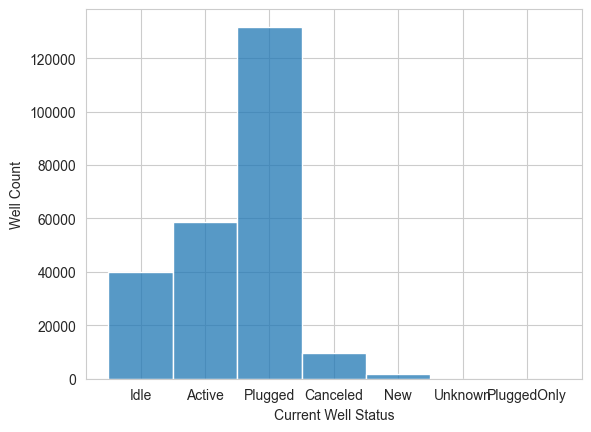

In [370]:
sns.histplot(well_list_df['WellStatus'], kde=False)
plt.ylabel('Well Count')
plt.xlabel('Current Well Status')

Text(0.5, 0, 'Current Well Status')

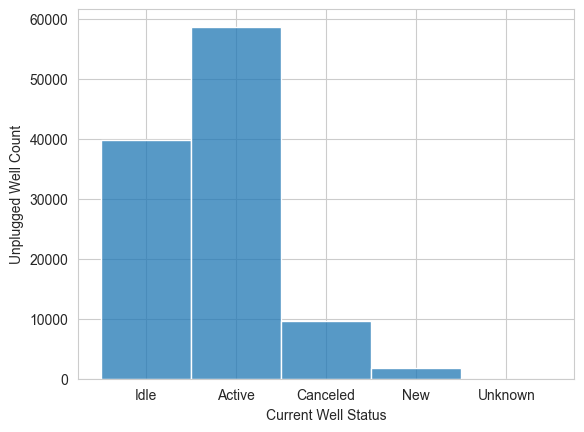

In [371]:
sns.histplot(well_list_df[~well_list_df['WellStatus'].isin(['Plugged','PluggedOnly'])]['WellStatus'], kde=False)
plt.ylabel('Unplugged Well Count')
plt.xlabel('Current Well Status')

In [372]:
# Separate out the idle wells
idle_df = well_list_df[well_list_df['WellStatus'] == 'Idle']

Text(0.5, 0, 'Last Volume Year')

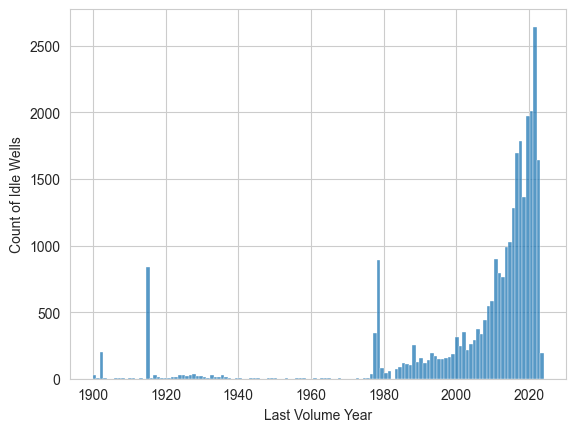

In [373]:
sns.histplot(idle_df['IdleYear'], kde=False)
plt.ylabel('Count of Idle Wells')
plt.xlabel('Last Volume Year')

Text(0.5, 0, 'Years Idle')

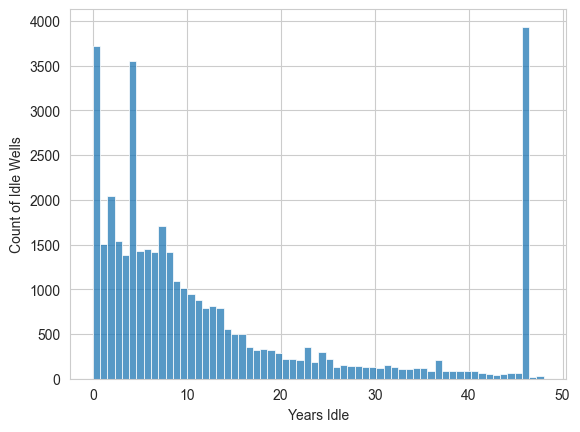

In [374]:
sns.histplot(idle_df['CalcYearsIdle'], kde=False)
plt.ylabel('Count of Idle Wells')
plt.xlabel('Years Idle')

## Idle well analysis by other attributes

Text(0.5, 0, 'Well Type')

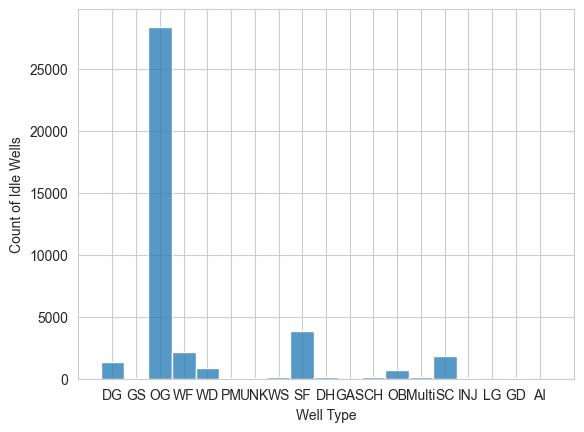

In [375]:
sns.histplot(idle_df['WellType'], kde=False)
plt.ylabel('Count of Idle Wells')
plt.xlabel('Well Type')

Idle well population is overwhelmingly `OG` which means Oil/Gas. Next runners up are `SF` and `SC` which is Steamflood and Cyclic Steam, respectively

Text(0.5, 0, 'Years Idle')

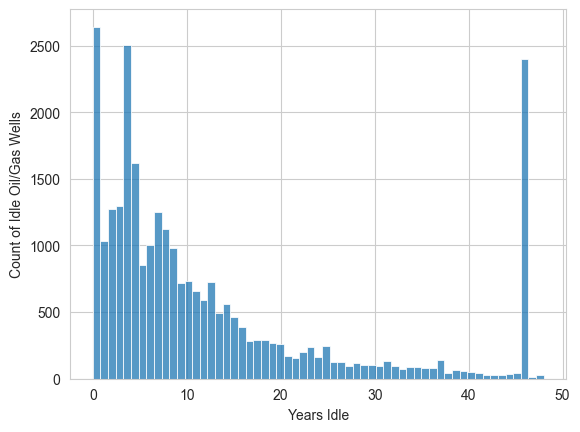

In [376]:
sns.histplot(idle_df[idle_df['WellType']=='OG']['CalcYearsIdle'], kde=False)
plt.ylabel('Count of Idle Oil/Gas Wells')
plt.xlabel('Years Idle')

Text(0.5, 0, 'Operator Size')

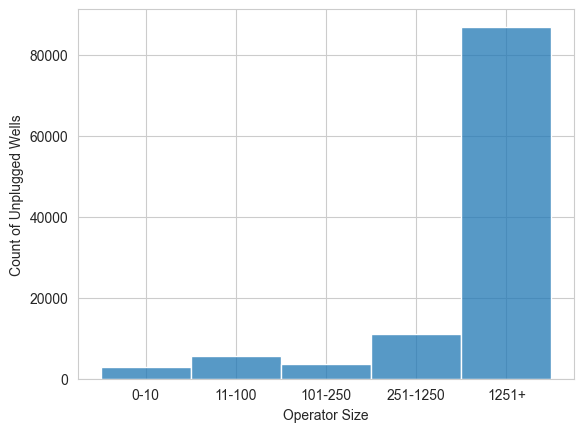

In [377]:
sns.histplot(unplugged_df['OperatorBin'], kde=False)
plt.ylabel('Count of Unplugged Wells')
plt.xlabel('Operator Size')

Text(0.5, 0, 'Operator Size')

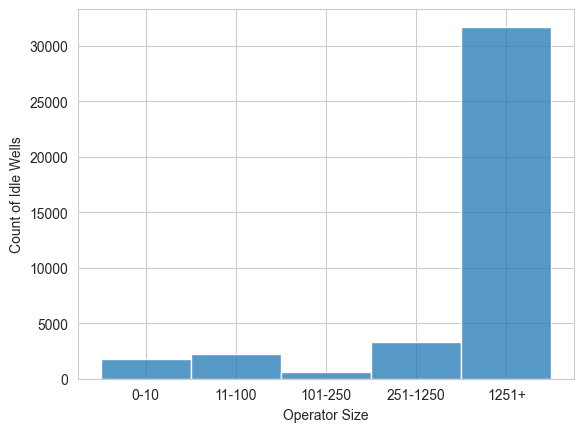

In [378]:
sns.histplot(unplugged_df[unplugged_df['WellStatus'] =='Idle']['OperatorBin'], kde=False)
plt.ylabel('Count of Idle Wells')
plt.xlabel('Operator Size')

In [379]:
op_df = pd.DataFrame(unplugged_df[unplugged_df['WellStatus'] =='Idle'].groupby('OperatorNa')['OperatorNa'].value_counts().copy())
op_df['OpSize'] = pd.cut(op_df['count'], bins=op_bins, labels=op_bin_labels)
op_df

,count,OpSize
OperatorNa,,
104 Oil & Drilling Co.,3,0-10
1301 Colton LLC,2,0-10
"1350 Court Partners, LP",2,0-10
"25 Hill Properties, Inc.",36,11-100
260 Resource Management LLC,12,11-100
...,...,...
Yoelin Family Trust,2,0-10
Young & Shaw,6,0-10
"Young Petroleum Corp., Ltd.",1,0-10


Text(0.5, 0, 'Operator Size')

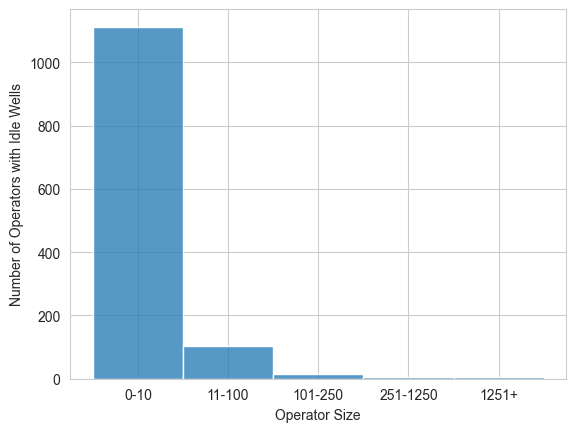

In [380]:
sns.histplot(op_df['OpSize'], kde=False)
plt.ylabel('Number of Operators with Idle Wells')
plt.xlabel('Operator Size')

Text(0.5, 0, 'Operator Size')

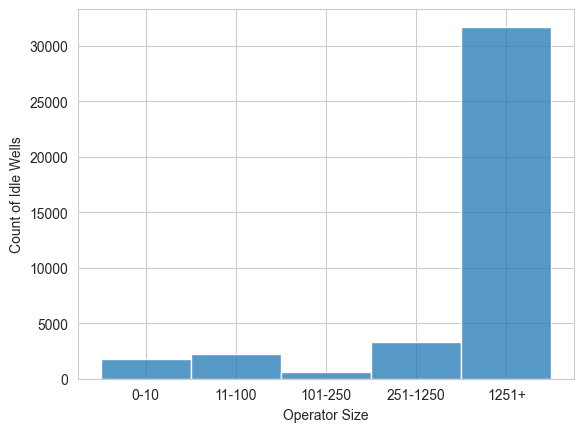

In [381]:
sns.histplot(unplugged_df[unplugged_df['WellStatus'] =='Idle']['OperatorBin'], kde=False)
plt.ylabel('Count of Idle Wells')
plt.xlabel('Operator Size')

### Assign the `op_df['at-risk']` back to the `unplugged_df` by operator

In [382]:
unplugged_df = pd.merge(unplugged_df, op_pivot[['AtRisk']], how='left', left_on='OperatorNa', right_index=True)
unplugged_df

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,OperatorWellCount,OperatorBin,IdleFees,AtRisk
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.000000,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.00,2040.0,False,0,0,0,1,1,0-10,1500,1
1,0402120723,Kauai,1-Mar,Kauai 3-1,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.440640,-121.951889,GPS,N,N,1999-12-07,Not Within HPZ,IdleDG,2015-08-01,8.416667,Yes,No,False,1999.0,2015.0,0402120723,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100,300,1
2,0402120734,Lanai,3-Mar,Lanai 3-3,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.447174,-121.961273,GPS,N,N,2000-05-13,Uncertainty Area,IdleDG,2015-08-01,8.416667,Yes,No,False,2000.0,2015.0,0402120734,2013-07-31,2013,2015-07-31,9.42,2040.0,False,0,0,0,1,47,11-100,300,1
3,0402120815,Anacapa,4-Mar,Anacapa 3-4,Idle,DG,Dry Gas,R4085,"Royale Energy, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,3,18N,01W,MD,39.443230,-121.951042,GPS,N,N,2002-11-06,Not Within HPZ,IdleDG,2011-06-01,12.583333,Yes,No,False,2002.0,2011.0,0402120815,2009-05-31,2009,2011-05-31,13.59,2040.0,False,0,0,0,1,47,11-100,300,1
4,0402120521,Angel Slough,1-Feb,Angel Slough 2-1,Active,DG,Dry Gas,C8720,"Crain Orchards, Inc.",Afton Gas,Main,Glenn County,Northern,Glenn,2,18N,01W,MD,39.449158,-121.946289,GPS,N,N,1988-02-17,Not Within HPZ,ActiveDG,NaT,NaN,NaN,NaN,False,1988.0,NaN,0402120521,2023-08-31,2023,NaT,0.00,2040.0,False,0,0,0,0,1,0-10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,0408301010,Quati,87,Quati 87,Active,OG,Oil & Gas,10379,"NewBridge Resources, LLC",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,3,07N,31W,SB,34.721378,-120.129692,GPS,N,N,NaT,Verified HPZ,ActiveOG,2023-02-01,0.916667,No,No,False,NaN,2023.0,0408301010,2024-12-31,2024,NaT,NaN,2040.0,False,0,0,0,0,488,251-1250,0,1
241873,0408301802,Luton,92,Luton 92,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,32,08N,31W,SB,34.736721,-120.163727,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301802,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0,1
241874,0408301803,Luton,93,Luton 93,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,29,08N,31W,SB,34.738331,-120.163513,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408301803,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0,1
241875,0408322941,Luton,NW-1,Luton NW-1,Active,OG,Oil & Gas,T3460,"Towne Exploration Company, LP",Zaca,Any Area,Santa Barbara County,Northern,Santa Barbara,30,08N,31W,SB,34.746796,-120.180992,Notice of Intent to Drill,N,N,NaT,Verified HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0408322941,2024-11-30,2024,NaT,0.00,2040.0,False,0,0,0,0,26,11-100,0,1


Text(0.5, 0, 'Operator Size')

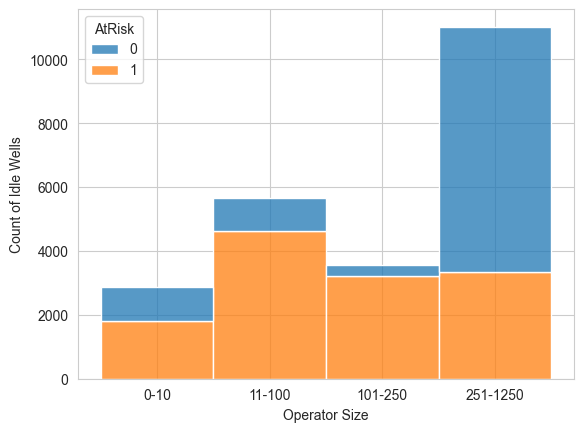

In [383]:
# map the smaller operators, and how many unplugged wells might be at-risk
sns.histplot(unplugged_df[unplugged_df['OperatorWellCount'] < 1250 ], x='OperatorBin',  kde=False, multiple='stack', hue='AtRisk')
plt.ylabel('Count of Idle Wells')
plt.xlabel('Operator Size')

# Baseline Model Building
- This may be too high-level, we may need Field level or some other subdivision on the `AtRisk` flag
- set up the train-test split datasets

## Model input prep

In [394]:
# Select the variables that seem to be of interest
X = unplugged_df[['WellStatus','WellType','CountyName','isDirectio','CalcIdleYear','OperatorBin','IdleFlag','IdleFees']].copy()
y = unplugged_df['AtRisk']

numeric_cols = ['CalcIdleYear','IdleFees']
categorical_cols = ['WellStatus','WellType','CountyName','isDirectio','OperatorBin','IdleFlag']

### Create categoricals

In [395]:
X = pd.get_dummies(X, columns=['WellStatus','WellType','CountyName','isDirectio','OperatorBin'], drop_first=True)
X

,CalcIdleYear,IdleFlag,IdleFees,WellStatus_Canceled,WellStatus_Idle,WellStatus_New,WellStatus_Unknown,WellType_CH,WellType_DG,WellType_DH,WellType_GAS,WellType_GD,WellType_GS,WellType_INJ,WellType_LG,WellType_Multi,WellType_OB,WellType_OG,WellType_PM,WellType_SC,WellType_SF,WellType_STR,WellType_UNK,WellType_WD,WellType_WF,WellType_WS,CountyName_Butte,CountyName_Colusa,CountyName_Contra Costa,CountyName_Fresno,CountyName_Glenn,CountyName_Humboldt,CountyName_Imperial,CountyName_Kern,CountyName_Kings,CountyName_Lake,CountyName_Lassen,CountyName_Los Angeles,CountyName_Los Angeles Offshore,CountyName_Madera,CountyName_Marin,CountyName_Merced,CountyName_Monterey,CountyName_Napa,CountyName_Orange,CountyName_Orange Offshore,CountyName_Riverside,CountyName_Sacramento,CountyName_San Benito,CountyName_San Bernardino,CountyName_San Diego,CountyName_San Joaquin,CountyName_San Luis Obispo,CountyName_San Mateo,CountyName_San Nicolas Island Offshore,CountyName_Santa Barbara,CountyName_Santa Barbara Offshore,CountyName_Santa Clara,CountyName_Siskiyou,CountyName_Solano,CountyName_Stanislaus,CountyName_Sutter,CountyName_Tehama,CountyName_Tulare,CountyName_Ventura,CountyName_Ventura Offshore,CountyName_Yolo,CountyName_Yuba,isDirectio_Y,OperatorBin_11-100,OperatorBin_101-250,OperatorBin_251-1250,OperatorBin_1251+
0,2040.0,1,1500,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2040.0,1,300,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,2040.0,1,300,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,2040.0,1,300,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,2040.0,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,2040.0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

### Scaling numeric features

In [396]:
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X

,CalcIdleYear,IdleFlag,IdleFees,WellStatus_Canceled,WellStatus_Idle,WellStatus_New,WellStatus_Unknown,WellType_CH,WellType_DG,WellType_DH,WellType_GAS,WellType_GD,WellType_GS,WellType_INJ,WellType_LG,WellType_Multi,WellType_OB,WellType_OG,WellType_PM,WellType_SC,WellType_SF,WellType_STR,WellType_UNK,WellType_WD,WellType_WF,WellType_WS,CountyName_Butte,CountyName_Colusa,CountyName_Contra Costa,CountyName_Fresno,CountyName_Glenn,CountyName_Humboldt,CountyName_Imperial,CountyName_Kern,CountyName_Kings,CountyName_Lake,CountyName_Lassen,CountyName_Los Angeles,CountyName_Los Angeles Offshore,CountyName_Madera,CountyName_Marin,CountyName_Merced,CountyName_Monterey,CountyName_Napa,CountyName_Orange,CountyName_Orange Offshore,CountyName_Riverside,CountyName_Sacramento,CountyName_San Benito,CountyName_San Bernardino,CountyName_San Diego,CountyName_San Joaquin,CountyName_San Luis Obispo,CountyName_San Mateo,CountyName_San Nicolas Island Offshore,CountyName_Santa Barbara,CountyName_Santa Barbara Offshore,CountyName_Santa Clara,CountyName_Siskiyou,CountyName_Solano,CountyName_Stanislaus,CountyName_Sutter,CountyName_Tehama,CountyName_Tulare,CountyName_Ventura,CountyName_Ventura Offshore,CountyName_Yolo,CountyName_Yuba,isDirectio_Y,OperatorBin_11-100,OperatorBin_101-250,OperatorBin_251-1250,OperatorBin_1251+
0,0.0,1,2.047394,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.0,1,-0.054760,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,0.0,1,-0.054760,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,0.0,1,-0.054760,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,0.0,0,-0.580299,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241872,0.0,0,-0.580299,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

### Train/Test Split

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## Baseline Model Training / Logistic Regression


In [398]:
logreg = LogisticRegression(random_state=452)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=452)

In [399]:
y_pred = logreg.predict(X_test)

In [402]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[28417,   694],
       [  866,  3035]])

Text(0.5, 427.9555555555555, 'Predicted label')

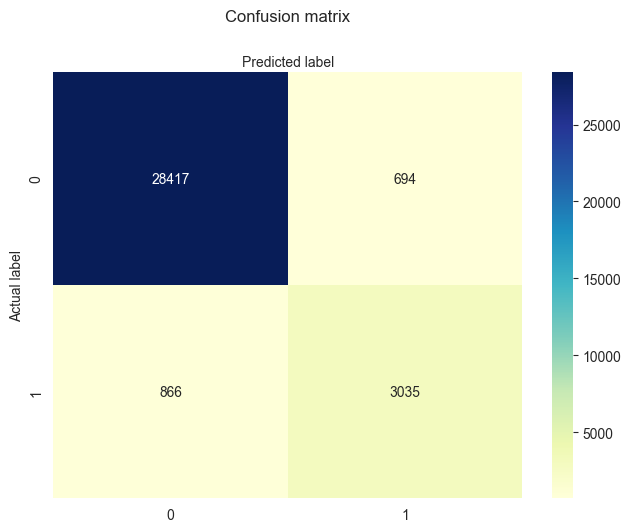

In [403]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Appendix SPUD date cleanup
Not really necessary now that I'm pulling last volume record dates directly from the monthly volumes table, but could be useful for other analysis so leaving it in an appendix


In [194]:
total_count_with_null_spud = well_list_df['SpudDate'].isna().sum()
idle_count_with_null_spud = well_list_df[(well_list_df['WellStatus']=='Idle') & (well_list_df['SpudDate'].isna())]['API'].count()
total_idle_count = well_list_df[well_list_df['WellStatus']=='Idle']['API'].count()

print(f"Total Count of NULL SPUD Date: {total_count_with_null_spud:,}")
print(f"Total Idle Count: {total_idle_count:,}")
print(f"Count of Idle Wells with NULL SPUD Date: {idle_count_with_null_spud:,} ({(idle_count_with_null_spud/total_idle_count):.0%})")

Total Count of NULL SPUD Date: 161,072
Total Idle Count: 39,786
Count of Idle Wells with NULL SPUD Date: 24,135 (61%)


In [195]:
# this resets the dataframe and removes any views
# well_list_df = well_list_df.copy()

In [196]:
well_list_df.value_counts('SpudDate').sort_index().head(15)

SpudDate
1801-01-01    8
1867-08-01    1
1882-03-25    1
1885-04-09    1
1886-02-12    1
1886-04-14    1
1886-05-31    1
1887-01-01    3
1887-01-21    1
1887-03-25    1
1887-04-15    1
1887-07-18    1
1887-08-02    1
1887-08-13    1
1887-08-18    1
Name: count, dtype: int64

In [197]:
# Check if there are any wells with status Idle but no Idle date
missing_idle_date = well_list_df[(well_list_df['WellStatus'] == 'Idle') & (well_list_df['IdleDate'].isna())]
print(f"Count of Idle Status wells with no Idle date set: {missing_idle_date['API'].count():,}")
missing_idle_date

Count of Idle Status wells with no Idle date set: 11,261


,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag
102,0403700771,Standard-Sesnon 1,19,Standard-Sesnon 1 19,Idle,OG,Oil & Gas,C9035,Crimson Resource Management Corp.,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.313702,-118.563377,GPS,N,Y,1951-12-22,Not Within HPZ,IdleOG,NaT,NaN,NaN,NaN,False,1951.0,NaN,0403700771,1978-11-30,1978,1980-11-30,44.08,1980.0,False,0,0,0,1
107,0403721362,Porter,26A,Porter 26A,Idle,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.315704,-118.557350,Well Summary,N,Y,1973-07-17,Not Within HPZ,IdleGS,NaT,NaN,NaN,NaN,False,1973.0,NaN,0403721362,2022-09-30,2022,2024-09-30,0.25,2024.0,False,0,0,0,0
112,0403721276,Porter,32B,Porter 32B,Idle,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,27,03N,16W,SB,34.312504,-118.550522,Well Summary,N,Y,1972-09-12,Not Within HPZ,IdleGS,NaT,NaN,NaN,NaN,False,1972.0,NaN,0403721276,2022-09-30,2022,2024-09-30,0.25,2024.0,False,0,0,0,0
113,0403721359,Fernando Fee,32C,Fernando Fee 32C,Idle,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles,Northern,Los Angeles,27,03N,16W,SB,34.313217,-118.539986,Well Summary,N,Y,1973-05-16,Not Within HPZ,IdleGS,NaT,NaN,NaN,NaN,False,1973.0,NaN,0403721359,2022-09-30,2022,2024-09-30,0.25,2024.0,False,0,0,0,0
117,0403700785,Standard-Sesnon 1,35,Standard-Sesnon 1 35,Idle,OG,Oil & Gas,C9035,Crimson Resource Management Corp.,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.317844,-118.566788,GPS,N,Y,NaT,Verified HPZ,IdleOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403700785,1986-07-31,1986,1988-07-31,36.42,1988.0,False,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235757,0403704489,Lease by Tidelands Oil Production Co.,UP413A,UP413A,Idle,OG,Oil & Gas,T2975,Tidelands Oil Production Co.,Wilmington,Fault Block I,Los Angeles,Southern,Los Angeles,4,05S,13W,SB,33.768555,-118.241798,Operator,N,Y,NaT,Verified HPZ,IdleOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403704489,1989-08-31,1989,1991-08-31,33.34,1991.0,False,0,0,0,1
235775,0403723827,Lease by Tidelands Oil Production Co.,UP956,UP956,Idle,OG,Oil & Gas,T2975,Tidelands Oil Production Co.,Wilmington,Fault Block II-A,Long Beach Offshore,Southern,Los Angeles,4,05S,13W,SB,33.762705,-118.240989,Well Summary,N,Y,1995-10-21,Verified HPZ,IdleOG,NaT,NaN,NaN,NaN,False,1995.0,NaN,0403723827,2020-12-31,2020,2022-12-31,2.00,2022.0,False,0,0,0,0
235779,0403702666,Lease by Tidelands Oil Production Co.,W 169,W 169,Idle,OG,Oil & Gas,T2975,Tidelands Oil Production Co.,Wilmington,Fault Block IV,Long Beach Offshore,Southern,Los Angeles,3,05S,13W,SB,33.762501,-118.221062,Operator,N,N,NaT,Not Within HPZ,IdleOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403702666,2024-11-30,2024,NaT,NaN,NaN,NaN,0,0,0,0
235784,0403702747,Lease by Tidelands Oil Production Co.,X 11,X 11,Idle,OG,Oil & Gas,T2975,Tidelands Oil Production Co.,Wilmington,Fault Block IV,Long Beach,Southern,Los Angeles,2,05S,13W,SB,33.761707,-118.217094,Operator,N,Y,NaT,Not Within HPZ,IdleOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403702747,2023-04-30,2023,NaT,NaN,NaN,NaN,0,0,0,0


In [198]:
print(f"Count of Idle wells with no Idle date or Spud Date set: {missing_idle_date['SpudDate'].count():,}")
print(f"Count of Idle wells with Spud Date but no Idle date set: {missing_idle_date['API'].count() - missing_idle_date['SpudDate'].count():,}")

Count of Idle wells with no Idle date or Spud Date set: 7,280
Count of Idle wells with Spud Date but no Idle date set: 3,981


## Data Wrangling on full data set
I think the data wrangling work will take place in 2 steps. First step is with all the data, and the second step will be specifically around the idle wells. For the first step, we can use the full dataset to help fill in gaps in the well data (i.e. potentially using location-based information to fill in missing values from nearest neighbors). The second step may take another pass on the idle well data to look for outliers or "bad" data.



### Step 1 : Nearest neighbors
As the lat/long data is the most complete feature, can I use nearest neighbors to impute some other missing values later (like SPUD date) ? This will be difficult given 61% of SPUD Dates are missing for the Idle status wells, but it's worth a look to see how big the variance is. 

Create the radian lat/longs for haversine formulas


In [199]:
well_list_df['lat_r'] = np.radians(well_list_df['Latitude'])
well_list_df['lng_r'] = np.radians(well_list_df['Longitude'])
print(f"Latitude Original: {well_list_df['Latitude'][1]} ; Converted to radians: {well_list_df['lat_r'][1]}")
print(f"Longitude Original: {well_list_df['Longitude'][1]} ; Converted to radians: {well_list_df['lng_r'][1]}")


Latitude Original: 39.4406395 ; Converted to radians: 0.6883690183671302
Longitude Original: -121.951889 ; Converted to radians: -2.1284619920766548


In [200]:
# Investigate an individual well... for example, well 0 doesn't have a Spud date so subtracting it's Idle Years from Idle Date gives us a fictitious date
# this is relevant because later I impute Spud Date various ways, and this Idle date is apparently fictitious, so I could wind up with Idle Dates before Spud Dates which is nonsensical
well_index = 0
print("Spud Date: ", well_list_df.loc[well_index, 'SpudYear'])
print("Idle Year: ", well_list_df.loc[well_index, 'IdleYear'])
print("Years Idle: ", well_list_df.loc[well_index, 'YearsIdle'])
print("Last Prod Calc Date: ", well_list_df.loc[well_index, 'IdleYear'] - well_list_df.loc[well_index, 'YearsIdle'])
print("Last Prod < Spud Date: ", well_list_df.loc[well_index, 'SpudYear'] < (well_list_df.loc[well_index, 'IdleYear'] - well_list_df.loc[well_index, 'YearsIdle']))

Spud Date:  nan
Idle Year:  1901.0
Years Idle:  123.0
Last Prod Calc Date:  1778.0
Last Prod < Spud Date:  False


In [201]:
# Construct the full tree
# some example code here for a large dataset: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
# tutorial on the problem: https://autogis-site.readthedocs.io/en/2019/notebooks/L3/nearest-neighbor-faster.html
# leaf_size impacts the size of the tree in memory and the speed of the queries. a tutorial linked above recommends 15 as a good starting point
# Note : I haven't specific the projection system, so the nearest neighbors will be correct, but probably not the distances
btree = BallTree(well_list_df[['lat_r','lng_r']], metric='haversine', leaf_size=15)
well_list_df[['API','Latitude','Longitude','lat_r','lng_r']][:5]

,API,Latitude,Longitude,lat_r,lng_r
0,0403300003,38.976693,-122.833093,0.680272,-2.143842
1,0402120723,39.440640,-121.951889,0.688369,-2.128462
2,0402120734,39.447174,-121.961273,0.688483,-2.128626
3,0402120815,39.443230,-121.951042,0.688414,-2.128447
4,0402120521,39.449158,-121.946289,0.688518,-2.128364


In [202]:
# Check for one location, get the 10 nearest neighbors (excluding itself):
# this only takes 21s on my computer, so fairly fast
earth_radius_miles = 3958.8
k = 12
well_dist, well_idx = btree.query(well_list_df[['lat_r','lng_r']], k=k+1)

# this drops the first column which is the self match, and multiplies up to miles of distance
well_dist = well_dist[:,1:] * earth_radius_miles 
well_dist[:5]

array([[ 3.32776372, 12.61907215, 19.22618989, 22.20623906, 22.21499021,
        22.49904302, 22.861539  , 23.00000573, 23.106965  , 23.11956824,
        23.27842531, 23.30933902],
       [ 0.18458203,  0.28946755,  0.36216658,  0.54180572,  0.5506731 ,
         0.61194205,  0.66005917,  0.67421977,  0.68998353,  0.75426401,
         0.89664261,  0.93803846],
       [ 0.14781818,  0.33166828,  0.43297706,  0.52783573,  0.58866361,
         0.61014215,  0.62220017,  0.64039644,  0.67421977,  0.81113152,
         0.87183941,  0.92937954],
       [ 0.18458203,  0.21414918,  0.39367675,  0.41594128,  0.48174847,
         0.50776943,  0.57282799,  0.58879036,  0.61014215,  0.63481472,
         0.77225567,  0.87720878],
       [ 0.24334525,  0.2672312 ,  0.28481839,  0.44494148,  0.48174847,
         0.4926349 ,  0.56274116,  0.58800811,  0.66005917,  0.66350274,
         0.73996333,  0.75490887]])

In [203]:
well_idx[:5]

array([[    0,  2680,  1481,  2682, 11742,  7295,  2681,  7245,  2684,
         7235,  7323,  2609,  7236],
       [    1,     3,     5,    22,    35,    33,    37,     4,     2,
           40,     8, 10503,    50],
       [    2,    37,    41,    22,    35,    50,     3,    40,     8,
            1,     4,     6,    33],
       [    3,     1,    22,     5,    33,     4,    40,     8,    37,
            2,    35,    50,     6],
       [    4,    40,    33,     8,    22,     3,     6,    50,    17,
            1,    25,    27,     5]])

In [204]:
# checked well 0 against its nearest neighbor on google earth, and it's indeed 3.33 miles away, so the calculations look good.
well_list_df.iloc[[0,2680]]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,lat_r,lng_r
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.0,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.0,1979.0,False,0,0,0,1,0.680272,-2.143842
2680,0403300001,Evelyn Awe,1,Evelyn Awe 1,Plugged,DH,Dry Hole,09267,William T. McKenzie,Any Field,Any Area,Lake County,Northern,Lake,28,13N,09W,MD,38.940266,-122.873611,hud,N,N,1949-05-18,Potentially HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1949.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.679636,-2.144549


### Google Earth measurement between well 0 and well 2680
<img src='source_pics\Screenshot 2025-01-08 210358.png'/>

In [205]:
# this pulls the list of nearest neighbors for the first well, which is missing it's SPUD date
# it appears that the neighboring wells were mainly drilled in the 1920s-1930s
well_list_df.iloc[well_idx[0,:]]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,lat_r,lng_r
0,0403300003,Lease by W.G. Young,1,1,Idle,DG,Dry Gas,11838,W.G. Young,Any Field,NaN,Lake County,Northern,Lake,14,13N,09W,MD,38.976693,-122.833093,Notice of Intent to Drill,N,N,NaT,Verified HPZ,IdleDG,1901-01-01,123.00,Yes,No,False,NaN,1901.0,NaN,1977-01-01,1977,1979-01-01,46.0,1979.0,False,0,0,0,1,0.680272,-2.143842
2680,0403300001,Evelyn Awe,1,Evelyn Awe 1,Plugged,DH,Dry Hole,09267,William T. McKenzie,Any Field,Any Area,Lake County,Northern,Lake,28,13N,09W,MD,38.940266,-122.873611,hud,N,N,1949-05-18,Potentially HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1949.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.679636,-2.144549
1481,0403300002,Lease by Lake County Drilling & Dev. Co.,1,1,Idle,DH,Dry Hole,05186,Lake County Drilling & Dev. Co.,Any Field,Any Area,Clearlake,Northern,Lake,35,13N,07W,MD,38.925224,-122.607765,hud,N,N,1924-03-30,Verified HPZ,IdleDH,1926-04-01,97.75,Yes,No,False,1924.0,1926.0,NaN,1977-01-01,1977,1979-01-01,46.0,1979.0,False,0,0,0,1,0.679373,-2.139909
2682,0409700053,Lease by Alexander Valley Oil Co.,1,1,Plugged,DH,Dry Hole,00212,Alexander Valley Oil Co.,Any Field,Any Area,Sonoma County,Northern,Sonoma,22,10N,09W,MD,38.698509,-122.841507,hud,N,N,1923-05-01,Potentially HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1923.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.675416,-2.143989
11742,0409700051,Lease by Skaggs Springs Oil & Gas Co.,2,2,Plugged,DH,Dry Hole,07888,Skaggs Springs Oil & Gas Co.,Any Field,Any Area,Sonoma County,Northern,Sonoma,24,10N,11W,MD,38.692799,-123.026497,Unknown,N,N,1923-10-10,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1923.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.675317,-2.147217
7295,0409700060,Lease by Skaggs Springs Oil & Gas Co.,1,1,Plugged,DH,Dry Hole,07888,Skaggs Springs Oil & Gas Co.,Any Field,Any Area,Sonoma County,Northern,Sonoma,24,10N,11W,MD,38.692699,-123.026604,Unknown,N,N,1923-08-31,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1923.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.675315,-2.147219
2681,0409700050,Lease by Beach & Landini,1,1,Plugged,DH,Dry Hole,00673,Beach & Landini,Any Field,Any Area,Sonoma County,Northern,Sonoma,4,09N,09W,MD,38.652409,-122.871033,hud,N,N,1922-12-21,Potentially HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1922.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.674612,-2.144504
7245,0401100250,Lease by Young Oil Co.,1,1,Plugged,DH,Dry Hole,09402,Young Oil Co.,Any Field,Any Area,Colusa County,Northern,Colusa,21,14N,05W,MD,39.044113,-122.416206,hud,N,N,1933-03-01,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1933.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.681448,-2.136566
2684,0409700140,Bidwell,1,Bidwell 1,Plugged,DH,Dry Hole,06081,Mortara Oil Co.,Any Field,Any Area,Sonoma County,Northern,Sonoma,8,09N,08W,MD,38.646648,-122.777458,hud,N,N,1930-01-01,Potentially HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1930.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.674511,-2.142871
7235,0401100251,Lease by D. & M. Oil Co.,1,1,Plugged,DH,Dry Hole,01966,D. & M. Oil Co.,Any Field,Any Area,Colusa County,Northern,Colusa,21,14N,05W,MD,39.040974,-122.410736,hud,N,N,1937-09-04,Potentially Not Within HPZ,PluggedDH,NaT,NaN,NaN,NaN,False,1937.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.681394,-2.136470


In [206]:
# this pulls the list of nearest neighbors for the 109 well, which is Idle and missing it's SPUD date
# it appears that the neighboring wells were mainly drilled in the 1920s-1930s
well_list_df.iloc[well_idx[109,:]]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,lat_r,lng_r
109,0403700715,Porter,28,Porter 28,Idle,OG,Oil & Gas,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314426,-118.555145,GPS,N,Y,NaT,Not Within HPZ,IdleOG,2000-04-01,23.75,Yes,No,False,NaN,2000.0,0403700715,2007-09-30,2007,2009-09-30,15.25,2009.0,False,0,0,0,1,0.598900,-2.069178
212,0403720642,Porter,73,Porter 73,Active,WF,Waterflood,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314434,-118.555328,Well Summary,N,N,1968-09-26,Not Within HPZ,ActiveWF,NaT,NaN,NaN,NaN,False,1968.0,NaN,0403720642,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598900,-2.069181
199,0403700750,Porter,69,Porter 69,Active,OG,Oil & Gas,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314896,-118.556465,GPS,N,Y,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403700750,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598908,-2.069201
194,0403700746,Porter,61,Porter 61,Active,OG,Oil & Gas,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.315277,-118.554108,GPS,N,N,NaT,Not Within HPZ,ActiveOG,NaT,NaN,NaN,NaN,False,NaN,NaN,0403700746,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598915,-2.069160
268,0403700716,Porter,29,Porter 29,Plugged,OG,Oil & Gas,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,27,03N,16W,SB,34.313969,-118.553657,hud,N,N,1950-10-09,Not Within HPZ,PluggedOG,NaT,NaN,NaN,NaN,False,1950.0,NaN,NaN,1977-01-01,1977,NaT,NaN,NaN,NaN,0,1,0,0,0.598892,-2.069152
200,0403722051,Porter,69A,Porter 69A,Active,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314846,-118.556831,Well Summary,N,Y,1980-01-03,Not Within HPZ,ActiveGS,NaT,NaN,NaN,NaN,False,1980.0,NaN,0403722051,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598907,-2.069207
331,0403724127,Porter,69B,Porter 69B,Plugged,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314968,-118.556831,Well Summary,N,Y,1992-01-28,Not Within HPZ,PluggedGS,NaT,NaN,NaN,NaN,False,1992.0,NaN,0403724127,2020-09-30,2020,NaT,NaN,NaN,NaN,0,1,1,0,0.598909,-2.069207
201,0403724128,Porter,69C,Porter 69C,Active,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314945,-118.556961,Well Summary,N,Y,1992-03-19,Not Within HPZ,ActiveGS,NaT,NaN,NaN,NaN,False,1992.0,NaN,0403724128,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598909,-2.069209
203,0403724138,Porter,69E,Porter 69E,Active,GS,Gas Storage,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.314810,-118.557072,Well Summary,N,Y,1993-06-23,Not Within HPZ,ActiveGS,NaT,NaN,NaN,NaN,False,1993.0,NaN,0403724138,2024-12-31,2024,NaT,NaN,NaN,NaN,0,0,0,0,0.598906,-2.069211
125,0403700737,Porter,52,Porter 52,Idle,WF,Waterflood,S4700,Southern California Gas Company,Aliso Canyon,Any Area,Los Angeles County,Northern,Los Angeles,28,03N,16W,SB,34.312870,-118.554398,Well Summary,N,N,NaT,Not Within HPZ,IdleWF,NaT,NaN,NaN,NaN,False,NaN,NaN,0403700737,2022-06-30,2022,2024-06-30,0.50,2024.0,False,0,0,0,0,0.598873,-2.069165


In [207]:
well_dist[109,1:]

array([0.08199997, 0.08343292, 0.09060668, 0.10049644, 0.10324599,
       0.10964983, 0.11312963, 0.11569386, 0.11759731, 0.12537593,
       0.12626936])

In [208]:
well_list_df.iloc[well_idx[109,:]]["SpudDate"][1:]

212   1968-09-26
199          NaT
194          NaT
268   1950-10-09
200   1980-01-03
331   1992-01-28
201   1992-03-19
203   1993-06-23
125          NaT
324   1951-08-05
202   1992-04-28
184   1943-11-02
Name: SpudDate, dtype: datetime64[ns]

In [209]:
# this takes the mid point of the non-null wells, excluding itself in position 0
print(well_list_df.iloc[well_idx[109,:]]["SpudDate"][1:].median())
print(well_list_df.iloc[well_idx[109,:]]["SpudDate"][1:].mean())
print(well_list_df.iloc[well_idx[109,:]]["SpudYear"][1:].var())


1980-01-03 00:00:00
1973-11-22 00:00:00
433.5277777777778


### Step 2 : Deal with missing values

I'm not sure how critical SpudDate will be, but since age of the well plays a role in the penalty structure, it is likely important for quantifying operator risk of penalties
 - create a column `SpudDate_I` that will contain the imputed `SpudDate` based on distance; I want to keep the original data clean for various slices
 - part 1 : wells that have blank `SpudDate` but have a set RECENT `IdleDate` (1977+) - can take nearby `SpudDate` of wells (like at least 5 nearest neighbors maybe, median based on distance less than certain number of miles.. maybe 10 miles to start)
 - part 2 : wells that have blank `SpudDate` but have a very OLD `IdleDate` (pre-1977) - may force these to 1977 for simplicity, the original source has random dates around 1900/1/1, which is useless
 - part 3 : Fix the part 1 wells so `SpudYear_I` is before `IdleDate` for all the wells 
  -  part 4 : Fix the part 2 wells so `SpudYear_I` and `IdleDate` make sense
 
### Missing Idle Dates : 
Most of the analysis in the end will be focused around `Idle` wells (or `Unknown`, which are missing data), and `Active` wells soon to become `Idle` so it will probably be beneficial to have solid Idle well data
 - create a column `IdleDate_I` that will contain the imputed `IdleDate`; there are **11,261**; I want to keep the original data clean for various slices
 - part 1 : wells that have `SpudDate` set and `WellStatus==Idle`, but blank `IdleDate` (based on EDA above there are **7,280** of these) - seems like it would be fairly simple to check last contiguous production 
 - part 2 : wells that have `WellStatus==Idle`, but blank `SpudDate` and `IdleDate` (based on EDA above there are **3,981** of these)

### Part 1 & 2 Imputation on Spud Date based on distance for recent Idle Dates
This is the most trivial part because the Idle dates and years are set, so we can calculate an average `SpudYear_I` and then check them individually against `IdleDate` to adjust as needed so SpudYear > IdleDate doesn't happen

In [210]:
 # [for x in well_list_df.index]
well_dist[369,:]

array([0.07821387, 0.07831914, 0.09516212, 0.10207724, 0.1041428 ,
       0.1259397 , 0.12850394, 0.14529185, 0.15891708, 0.17578241,
       0.19887089, 0.20620505])

In [211]:
# Imputes the SpudYear mean from the nearest neighbors as calculated in the BallTree above
# Used in the df.apply() method below
# it checks each row to see if SpudDate is empty, and if so, pulls the nearest neighbor indices from the well_idx list calculated above in EDA
# then if that list of neighbors' SpudDates is not empty, it returns the median 
def impute_spudyear_from_nn( row, well_idx_list, df):
    # in this context, row.name contains the integer row index
    if pd.isnull(row['SpudDate']):
        # get the indices of the nearest neighbors for this row and skip the first index (itself)
        #neighbors_idx = df.iloc[well_idx_list[row.name, 1:]]["SpudYear"].dropna()  
        neighbors_idx = well_idx_list[row.name, 1:]
        neighbors = df.iloc[neighbors_idx]["SpudYear"].dropna()
        if not neighbors.empty:
            return neighbors.mean()
        else:
            return np.nan
    # when there is a SpudYear already, just keep it
    return row['SpudYear']

#well_list_df['SpudYear_I'] = [well_list_df.iloc[well_idx[x, 1:]]["SpudYear"].median() if pd.isna(well_list_df.loc[x, 'SpudDate']) else well_list_df.loc[x, 'SpudYear'] for x in well_list_df.index]

well_list_df['SpudYear_I'] = well_list_df.apply(impute_spudyear_from_nn, axis=1, args=(well_idx, well_list_df))


In [212]:
print(f"Number of wells in active field areas missing SpudYear before imputation: {well_list_df[(well_list_df['SpudYear'].isna()) & (well_list_df['FieldAbd'] == False)]['API'].count():,}")
print(f"Number of wells in active field areas remaining without imputed SpudYear: {well_list_df[(well_list_df['SpudYear_I'].isna()) & (well_list_df['FieldAbd'] == False)]['API'].count():,}")
print(f"Number of wells in with imputed SpudYear but SpudYear >= IdleYear: {well_list_df[(well_list_df['SpudYear_I'] >= (well_list_df['IdleYear']-2.0)) & (well_list_df['FieldAbd'] == False)]['API'].count():,}")

Number of wells in active field areas missing SpudYear before imputation: 155,023
Number of wells in active field areas remaining without imputed SpudYear: 43,635
Number of wells in with imputed SpudYear but SpudYear >= IdleYear: 3,022


### Calculate Avg years between Spud and Idle for the Operator and Field and Area, we can use it for correcting the missing Spud Years where Spud > Idle date
There are 3,022 wells that have an imputed SpudYear >= IdleYear + 2, so those need to be corrected. First I'll set them all to NaN, and then calculate a replacement. 
Starting default to 20 years from Spud to Idle if there aren't at least 2 instance of these dates already

In [213]:
# Helper column of production years : ProdYears = IdleYears - SpudYear - 2 inactive years
well_list_df['ProdYears'] = well_list_df['IdleYear'] - well_list_df['SpudYear'] - 2

f_spud_to_idle = lambda x : x.mean() if x.count() >= 2 else 20

well_list_df[(well_list_df['SpudYear_I'] >= (well_list_df['IdleYear']-2.0)) & (well_list_df['FieldAbd'] == False)]['SpudYear_I'] = np.nan
print(f"Count of NaN in imputed SpudYear: {well_list_df['SpudYear_I'].isna().count():,}")

well_list_df['SpudYear_I'] = well_list_df['SpudYear_I'].fillna(well_list_df.groupby(['OperatorCo', 'FieldName', 'WellType', 'AreaName'])['ProdYears'].transform(f_spud_to_idle))
print(f"Count of NaN in after correcting SpudYear_I: {well_list_df['SpudYear_I'].isna().count():,}")

Count of NaN in imputed SpudYear: 241,912


C:\Users\dan\AppData\Local\Temp\ipykernel_31136\3440102312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_list_df[(well_list_df['SpudYear_I'] >= (well_list_df['IdleYear']-2.0)) & (well_list_df['FieldAbd'] == False)]['SpudYear_I'] = np.nan


Count of NaN in after correcting SpudYear_I: 241,912


In [214]:
list(well_list_df.groupby(['OperatorCo', 'FieldName', 'WellType', 'AreaName'])[['IdleYear','SpudYear']])[230:250]

[(('00269', 'Any Field', 'DH', 'Any Area'),
        IdleYear  SpudYear
  6887       NaN       NaN),
 (('00270', 'Long Beach', 'OG', 'Northwest Extension'),
          IdleYear  SpudYear
  136259       NaN       NaN),
 (('00271', 'Any Field', 'DH', 'Any Area'),
        IdleYear  SpudYear
  9121       NaN    1951.0),
 (('00273', 'Any Field', 'DH', 'Any Area'),
        IdleYear  SpudYear
  4502       NaN       NaN),
 (('00274', 'Any Field', 'DH', 'Any Area'),
        IdleYear  SpudYear
  5547       NaN       NaN),
 (('00275', 'Any Field', 'DH', 'Any Area'),
         IdleYear  SpudYear
  5397        NaN       NaN
  11283       NaN       NaN),
 (('00277', 'Any Field', 'DH', 'Any Area'),
        IdleYear  SpudYear
  2875       NaN    1960.0
  3040       NaN    1960.0),
 (('00278', 'Richfield', 'OG', 'Any Area'),
          IdleYear  SpudYear
  209747       NaN       NaN),
 (('00279', 'Any Field', 'DH', 'Any Area'),
         IdleYear  SpudYear
  13622       NaN       NaN
  14002       NaN      

### Imputation on SpudDate of wells based on similar attributes like Field Area and Operator; an alternative to doing it by distance above

In [215]:
# lambda function to be used for the imputation.
# Choosing median here because most field areas have a few years of intensive drilling by
# an operator, and may have a few outliers from very early exploration wells, or very recent
# redevelopment attempts.
# Arbitrarily choosing 5 as a start point for minimum count on the grouping
f_spud = lambda x: x.median() if x.count() >= 5 else np.nan

print(f"original SPUD year NaN count: {well_list_df['SpudYear'].isna().sum():,}")

well_list_df['SpudYear_T'] = well_list_df['SpudYear'].fillna(well_list_df.groupby(['OperatorCo', 'FieldName', 'WellType', 'AreaName', 'IdleYear'])['SpudYear'].transform(f_spud))

print(f"first pass SPUD year NaN count: {well_list_df['SpudYear_T'].isna().sum():,}")

# 6,579 wells have 5 or more matches on 'OperatorCo', 'FieldName', 'WellType', 'AreaName', 'IdleYear'
# my hypothesis is that these are mainly going to be in the giant fields, and under the large operators so not very interesting
temp_df = well_list_df[well_list_df['SpudYear'].isna() & well_list_df['SpudYear_T'].notna()]
temp_df

original SPUD year NaN count: 161,072
first pass SPUD year NaN count: 154,493


,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,lat_r,lng_r,SpudYear_I,ProdYears,SpudYear_T
729,0403037541,Carlton Investment,404I-15,Carlton Investment 404I-15,Idle,SF,Steamflood,C0885,California Resources Production Corporation,"Antelope Hills, North",Any Area,Kern County,Inland,Kern,15,27S,19E,MD,35.577599,-119.909912,GPS,N,N,NaT,Not Within HPZ,IdleSF,2023-08-01,0.416667,No,No,False,NaN,2023.0,0403037541,2021-07-31,2021,2023-07-31,1.42,2023.0,True,0,0,0,0,0.620946,-2.092823,2003.571429,NaN,2011.0
16287,0402927026,"Lease by California Resources Elk Hills, LLC",381-26Z,381-26Z,Idle,OG,Oil & Gas,C0880,"California Resources Elk Hills, LLC",Asphalto,Any Area,Kern County,Inland,Kern,26,30S,22E,MD,35.295437,-119.572456,GPS,N,N,NaT,Not Within HPZ,IdleOG,2015-03-01,8.833333,Yes,No,False,NaN,2015.0,0402927026,2013-02-28,2013,2015-02-28,9.84,2015.0,True,0,0,0,1,0.616022,-2.086933,2014.666667,NaN,2009.5
18164,0402935069,Unspecified,28-Jan,Unspecified 1-28,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,28,27S,20E,MD,35.556290,-119.815262,Operator,N,N,NaT,Not Within HPZ,IdleOG,2019-10-01,4.250000,No,No,False,NaN,2019.0,0402935069,2017-09-01,2017,2019-09-01,5.33,2019.0,True,0,0,0,1,0.620574,-2.091171,12.580357,NaN,2011.0
18165,0402929622,Unspecified,1-Y-28,Unspecified 1-Y-28,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,28,27S,20E,MD,35.556065,-119.815529,Operator,N,N,NaT,Not Within HPZ,IdleOG,2021-03-01,2.833333,No,No,False,NaN,2021.0,0402929622,2019-02-28,2019,2021-02-28,3.84,2021.0,True,0,0,0,1,0.620570,-2.091175,12.580357,NaN,2008.5
18169,0403031094,Reynolds-Knudsen,12G1-36,Reynolds-Knudsen 12G1-36,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,36,27S,20E,MD,35.540470,-119.777565,Operator,N,Y,NaT,Not Within HPZ,IdleOG,2011-07-01,12.500000,Yes,No,False,NaN,2011.0,0403031094,2009-06-30,2009,2011-06-30,13.51,2011.0,True,0,0,0,1,0.620298,-2.090513,2010.000000,NaN,1997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235597,0423722693,Lease by THUMS Long Beach Co.,D-543 I,D-543 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,17,05S,12W,SB,33.740761,-118.163444,Operator,N,Y,NaT,Not Within HPZ,IdleOG,2020-03-01,3.833333,No,No,False,NaN,2020.0,0423722693,2019-12-31,2019,2021-12-31,3.00,2021.0,False,0,0,0,0,0.588887,-2.062341,1981.666667,NaN,2017.0
235601,0423720518,Lease by THUMS Long Beach Co.,D-596 I,D-596 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,17,05S,12W,SB,33.741703,-118.163117,Operator,N,Y,NaT,Not Within HPZ,IdleOG,2020-03-01,3.833333,No,No,False,NaN,2020.0,0423720518,2020-12-31,2020,2022-12-31,2.00,2022.0,False,0,0,0,0,0.588904,-2.062335,1979.600000,NaN,2017.0
235656,0403700618,Lease by THUMS Long Beach Co.,J-141,J-141,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach,Southern,Los Angeles,12,05S,13W,SB,33.752281,-118.195320,Operator,N,N,NaT,Verified HPZ,IdleOG,2018-10-01,5.250000,No,No,False,NaN,2018.0,NaN,2016-10-01,2016,2018-10-01,6.25,2018.0,True,0,0,0,1,0.589088,-2.062897,2013.000000,NaN,1986.0
235677,0403701040,Lease by THUMS Long Beach Co.,J-510 I,J-510 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach,Southern,Los Angeles,13,05S,13

In [216]:
# examine the hypothesis
temp_df.value_counts('OperatorNa')

OperatorNa
Aera Energy LLC                                   2377
Chevron U.S.A. Inc.                               2105
Berry Petroleum Company, LLC                       657
California Resources Elk Hills, LLC                579
Sentinel Peak Resources California LLC             415
E & B Natural Resources Management Corporation     121
Bridgeland Resources, LLC                           79
California Resources Production Corporation         73
Crimson Resource Management Corp.                   36
Naftex Operating Company                            25
Tidelands Oil Production Co.                        22
HVI Cat Canyon, Inc.                                14
THUMS Long Beach Co.                                11
Patriot Resources, LLC                              10
First Oil and Gas Company                           10
CalNRG Operating, LLC                                9
Macpherson Oil Company                               9
Southern California Gas Company                      6

In [217]:
t5_count = temp_df.value_counts('OperatorNa').head(5).sum()
print(f"Top 5 operators have {t5_count:,} of the {temp_df['OperatorNa'].count():,} wells in this group ({t5_count/temp_df['OperatorNa'].count():.0%}) - so this is a safe imputation that likely won't affect the overall analysis")

Top 5 operators have 6,133 of the 6,579 wells in this group (93%) - so this is a safe imputation that likely won't affect the overall analysis


In [218]:
# check if any of them have SpudDate_I > IdleDate - IdleYears - 2
temp_df[temp_df['SpudYear_T'] > (temp_df['IdleYear'] - temp_df['YearsIdle'] - 2.0)]

,API,LeaseName,WellNumber,WellDesign,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,FieldName,AreaName,Place,District,CountyName,Section,Township,Range,BaseMeridi,Latitude,Longitude,GISSource,isConfiden,isDirectio,SpudDate,inHPZ,WellSymbol,IdleDate,YearsIdle,IsLTIW,UnsatAbandon,FieldAbd,SpudYear,IdleYear,api_10,last_date,LastProdYear,CalcIdleDate,CalcYearsIdle,CalcIdleYear,IsIdleYearSame,UnsatAbandonFlag,PluggedFlag,PluggedRecentFlag,IdleFlag,lat_r,lng_r,SpudYear_I,ProdYears,SpudYear_T
16287,0402927026,"Lease by California Resources Elk Hills, LLC",381-26Z,381-26Z,Idle,OG,Oil & Gas,C0880,"California Resources Elk Hills, LLC",Asphalto,Any Area,Kern County,Inland,Kern,26,30S,22E,MD,35.295437,-119.572456,GPS,N,N,NaT,Not Within HPZ,IdleOG,2015-03-01,8.833333,Yes,No,False,NaN,2015.0,0402927026,2013-02-28,2013,2015-02-28,9.84,2015.0,True,0,0,0,1,0.616022,-2.086933,2014.666667,NaN,2009.5
18169,0403031094,Reynolds-Knudsen,12G1-36,Reynolds-Knudsen 12G1-36,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,36,27S,20E,MD,35.540470,-119.777565,Operator,N,Y,NaT,Not Within HPZ,IdleOG,2011-07-01,12.500000,Yes,No,False,NaN,2011.0,0403031094,2009-06-30,2009,2011-06-30,13.51,2011.0,True,0,0,0,1,0.620298,-2.090513,2010.000000,NaN,1997.0
18172,0402935071,Unspecified,16-28,Unspecified 16-28,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,28,27S,20E,MD,35.554325,-119.815269,Operator,N,N,NaT,Not Within HPZ,IdleOG,2018-06-01,5.583333,No,No,False,NaN,2018.0,0402935071,2017-07-01,2017,2019-07-01,5.50,2019.0,False,0,0,0,1,0.620540,-2.091171,12.580357,NaN,2013.0
18194,0402935075,Unspecified,Mar-35,Unspecified 3-35,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,35,27S,20E,MD,35.541695,-119.784538,Operator,N,N,NaT,Not Within HPZ,IdleOG,2011-09-01,12.333333,Yes,No,False,NaN,2011.0,0402935075,2009-08-31,2009,2011-08-31,13.34,2011.0,True,0,0,0,1,0.620320,-2.090635,12.580357,NaN,1997.0
18221,0402979196,Result,47E-36,Result 47E-36,Idle,OG,Oil & Gas,A0610,Aera Energy LLC,"Belridge, North",Any Area,Kern County,Inland,Kern,36,27S,20E,MD,35.531673,-119.771767,Operator,N,N,NaT,Not Within HPZ,IdleOG,2011-09-01,12.333333,Yes,No,False,NaN,2011.0,0402979196,2009-08-31,2009,2011-08-31,13.34,2011.0,True,0,0,0,1,0.620145,-2.090412,1986.000000,NaN,1997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235465,0423720198,Lease by THUMS Long Beach Co.,A-668 I,A-668 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,7,05S,12W,SB,33.759373,-118.182655,Operator,N,Y,NaT,Verified HPZ,IdleOG,2020-05-01,3.666667,No,No,False,NaN,2020.0,0423720198,2019-12-31,2019,2021-12-31,3.00,2021.0,False,0,0,0,0,0.589212,-2.062676,1994.666667,NaN,2017.0
235526,0423726419,Lease by THUMS Long Beach Co.,B-603 I,B-603 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,8,05S,12W,SB,33.752281,-118.160355,Operator,N,Y,NaT,Verified HPZ,IdleOG,2020-03-01,3.833333,No,No,False,NaN,2020.0,0423726419,2020-12-31,2020,2022-12-31,2.00,2022.0,False,0,0,0,0,0.589088,-2.062287,2000.000000,NaN,2017.0
235597,0423722693,Lease by THUMS Long Beach Co.,D-543 I,D-543 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,17,05S,12W,SB,33.740761,-118.163444,Operator,N,Y,NaT,Not Within HPZ,IdleOG,2020-03-01,3.833333,No,No,False,NaN,2020.0,0423722693,2019-12-31,2019,2021-12-31,3.00,2021.0,False,0,0,0,0,0.588887,-2.062341,1981.666667,NaN,2017.0
235601,0423720518,Lease by THUMS Long Beach Co.,D-596 I,D-596 I,Idle,OG,Oil & Gas,T2900,THUMS Long Beach Co.,Wilmington,Fault Block VI,Long Beach Offshore,Southern,Los Angeles Offshore,17,05S,12W,SB,

In [219]:
well_list_df['SpudYear_T2'] = well_list_df['SpudYear_T'].fillna(well_list_df.groupby(['OperatorCo', 'FieldName', 'IdleYear'])['SpudYear_T'].transform(f_spud))

print(f"2nd pass SPUD year NaN count: {well_list_df['SpudYear_T2'].isna().sum():,}")

2nd pass SPUD year NaN count: 152,263


In [220]:
# Swap out IdleYear with AreaName
well_list_df['SpudYear_T3'] = well_list_df['SpudYear_T2'].fillna(well_list_df.groupby(['OperatorCo', 'FieldName', 'AreaName'])['SpudYear_T2'].transform(f_spud))

print(f"3rd pass SPUD year NaN count: {well_list_df['SpudYear_T3'].isna().sum():,}")

3rd pass SPUD year NaN count: 49,304


In [221]:
# Now combine all Operators, but differentiate by AreaName and IdleYear
well_list_df['SpudYear_T4'] = well_list_df['SpudYear_T3'].fillna(well_list_df.groupby(['FieldName', 'WellType', 'AreaName', 'IdleYear'])['SpudYear_T3'].transform(f_spud))

print(f"4th pass SPUD year NaN count: {well_list_df['SpudYear_T4'].isna().sum():,}")

4th pass SPUD year NaN count: 48,805


In [222]:
# Now combine all Operators, but differentiate by AreaName only
well_list_df['SpudYear_T5'] = well_list_df['SpudYear_T4'].fillna(well_list_df.groupby(['FieldName', 'WellType', 'AreaName'])['SpudYear_T4'].transform(f_spud))

print(f"5th pass SPUD year NaN count: {well_list_df['SpudYear_T5'].isna().sum():,}")

5th pass SPUD year NaN count: 15,442


In [223]:
# Now combine all Operators, and AreaNames
well_list_df['SpudYear_T6'] = well_list_df['SpudYear_T5'].fillna(well_list_df.groupby(['FieldName', 'WellType'])['SpudYear_T5'].transform(f_spud))

print(f"6th pass SPUD year NaN count: {well_list_df['SpudYear_T6'].isna().sum():,}")

6th pass SPUD year NaN count: 10,681


In [224]:
# Now combine all WellTypes but differentiate IdleYear
well_list_df['SpudYear_T7'] = well_list_df['SpudYear_T6'].fillna(well_list_df.groupby(['FieldName', 'IdleYear'])['SpudYear_T6'].transform(f_spud))

print(f"7th pass SPUD year NaN count: {well_list_df['SpudYear_T7'].isna().sum():,}")

7th pass SPUD year NaN count: 10,663


In [225]:
# Now combine all FieldNames
well_list_df['SpudYear_T7'] = well_list_df['SpudYear_T6'].fillna(well_list_df.groupby(['FieldName', 'IdleYear'])['SpudYear_T6'].transform(f_spud))

print(f"7th pass SPUD year NaN count: {well_list_df['SpudYear_T7'].isna().sum():,}")

7th pass SPUD year NaN count: 10,663


# Appendix - Metadata & Data Dictionary


## Main categories:  Status and Type

**Well Status** single code identifying current status of well. Single code stands for:
- A = Active (well has been drilled and completed and in-use)
- B = Buried (well is buried and idle)
- C = Cancelled (well permit has been cancelled prior to drilling)
- I = Idle (well is idle, not produced or injected for 6 consecutive months for two years)
- N = New (recently permitted well; planned or in the process of being drilled)
- P = Plugged & Abandoned (well has been plugged and abandoned to current standards)
- U = Unknown (well status not known; mostly older wells dated on pre-1976)

**Well Type Codes**
AI = Air Injector
CH = Core Hole
DG = Dry Gas
DH = Dry Hole
GAS = Gas
GD = Gas Disposal
GI = Gas Injection
GS = Gas Storage
INJ = Injection
LG = Liquid Petroleum Gas
Multi = Multiple Types
OB = Observation
OG = Oil & Gas
PM = Pressure Maintenance
SC = Cyclic Steam
SF = Steam Flood
UNK = Unknown well type; often a historic or legacy (pre-1976) well
WD = Water Disposal
WF = Water Flood
WS = Water Source




## Features names and descriptions
This is my current understanding of the CSV data file description of the fields

|Field Name| Data type | Width | description of record                                                                                                                                                                                |
|---|-----------|-------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|OID| 	Integer  | 	4    | 	Internal feature number OBJECTID: Sequential unique whole numbers that are automatically generated.                                                                                                 |
|API| 	String   | 	10   | 	API Number. Unique and permanent identifier assigned to each well as standardized by the American Petroleum Institute                                                                               |
|LeaseName| 	String   | 	109  | 	Lease name of oil and gas wells. At situation when lease name of that well is unknown, the location in which well is located (i.e. section, township, range, longitude, latitude) is then recorded. |
|WellNumber| 	String   | 	50   | 	Operator-assigned alpha numeric designation for well.                                                                                                                                               |
|WellDesign| 	String   | 	     | 	???                                                                                                                                                                                                 |
|WellStatus| 	String   | 	     | 	Well Status - single code identifying current status of well  (see below)                                                                                                                           |
|WellType| 	String   | 	     | 	Codes indicating well type  (see below)                                                                                                                                                             |
|WellTypeLa| 	String   | 	     | 	Likely well type label                                                                                                                                                                              |
|OperatorCo| 	String   | 	12   | 	Operator code. Unique identifier number assigned to each operator                                                                                                                                   |
|OperatorNa| 	String   | 	100  | 	Operator Name. Name of individual or company or organization responsible for managment and operations of wells.                                                                                     |
|FieldName| 	String   | 	255  | 	Name of the oil and gas field in which the well is located                                                                                                                                          |
|AreaName| 	String   | 	255  | 	Name of area in which well is located                                                                                                                                                               |
|Place| 	String   | 	     | 	Keyword                                                                                                                                                                                             |
|District| 	String   | 	255  | 	DOGGR district with jurisdiction over the location in which well is located                                                                                                                         |
|CountyName| 	String   | 	50   | 	County with jurisdiction over the location in which well is located                                                                                                                                 |
|Section| 	Integer  | 	50   | 	Public Land Survey System section number in which well is located                                                                                                                                   |
|Township| 	String   | 	100  | 	Public Land Survey System township in which well is located                                                                                                                                         |
|Range| 	String   | 	100  | 	Public Land Survey System range in which well is located                                                                                                                                            |
|BaseMeridi| 	String   | 	50   | 	Base Meridian. Principle meridians required for all California surveys; defines PLSS base; H = Humboldt; MD = Mount Diablo; SB = San Bernardino                                                     |
|Latitude| 	Double   | 	8    | 	Latitude of well in the NAD83 coordinate system; decimal degree format                                                                                                                              |
|Longitude| 	Double   | 	8    | 	Longitude of well in the NAD83 coordinate system; decimal degree format                                                                                                                             |
|GISSource| 	String   | 	3    | 	3-character code describing the method by which the well location was established (see below)                                                                                                       |
|isConfiden| 	String   | 	1    | 	Confidential Well. Subsurface information for well is held confidential for a period of two years pursuant to Public Resources Code section 3234                                                    |
|isDirectio| 	String   | 	1    | 	Directionally Drilled. Indicator of whether well was directionally drilled; NULL for confidential wells                                                                                             |
|SpudDate| 	String   | 	8    | 	Date on which well drilling commenced                                                                                                                                                               |
|inHPZ| 	String   | 	26   | 	Well Intersection with Health Protection Zone (HPZ) (see below)                                                                                                                                     |
|WellSymbol| 	String   | 	15   | 	Code for GIS symbology (see below)|

## Additional Codes:


**Pre-2021 Well Production Type Codes**
- 1 - Non-Associated Gas Withdrawal (aka Dry Gas)
- 2 - Oil and Associated Gas Withdrawal
- 3 - Gas Storage Withdrawal
- 5 - Liquified Petroleum Gas Storage Withdrawal
- 9 - Water Source

**Pre-2021 Well Injection Type Codes**
- 3 - Gas Storage Injection
- 4 - Pressure Maintenance (Gas Injection)
- 5 - Liquified Petroleum | Gas Injection (Propane, Butane, Olefin, etc.)
- 6 - Water Disposal
- 7 - Water Flood
- 8 - Steam Flood
- 0 - Air Injection
- A - Cyclic Steam Injection

**Pre-2021 Method of Operation (MO)**
- 0 - Not Applicable
- 1 - Flowing
- 2 - Jack Line
- 3 - Beam Rod Pump
- 4 - Hydraulic Rod Pump
- 5 - Bottom-Hole Hydraulic Rod Pump
- 6 - Bottom-Hole Electric Pump (ESP)
- 7 - Gas Lift
- 8 - Other

**Pre-2021 Water Disposition (Disp)**
- 0 - Not Applicable
- 1 - Evaporation-Percolation
- 2 - Evaporation (lined sump)
- 3 - Surface Water Body
- 4 - Sewer System
- 5 - Subsurface Injection
- 6 - Other (i.e. turned over to commercial water disposal)

**Pre-2021 Reason Well Not In Production**
- 0 - Well on production
- 1 - Standing (incapable of production in present condition)
- 4 - Uncompleted
- 5 - Abandoned or converted to another well type (DOGGR Approved)
- 6 - Shut-In (capable of production in its present condition)
- 8 - Other (i.e., observation well)
- 9 - Operator Change (well transferred)

**Pre-2021 Source of Water**
- 0 - Not Applicable
- 1 - Oil or Gas Well
- 2 - Water Source System
- 3 - Domestic Water System
- 4 - Ocean
- 5 - Industrial Waste
- 6 - Domestic Waste
- 7 - Other

**Pre-2021 Kind of Water**
- 0 - Not Applicable
- 1 - Saline
- 2 - Fresh
- 3 - Chemical Mixture
- 4 - Other

**Pre-2021 Reason Well Not Injecting (equivalent to Not Producing list)**
- 0 - Well injecting
- 1 - Standing (incapable of production in present condition)
- 4 - Uncompleted
- 5 - Abandoned or converted to another well type (DOGGR Approved)
- 6 - Shut-Down (capable of production in its present condition)
- 8 - Other (i.e., observation well)
- 9 - Operator Change (well transferred)


**GIS Source**: 3-character code describing the method by which the well location was established
(Ranked from most accurate to least accurate)
GPS = Global Positioning System (Coordinates derived from Division staff and Trimble GPS unit)
OPR = Operator (Coordinates provided by Operator via electronic format; ex. Excel, db, etc.)
SUM = Well Summary Report (Coordinates provided by Operator, post-drilling, on SUM)
NOI = Notice of Intent to Drill (Coordinates provided by Operator, pre-drilling, on NOI)
DOQ = Digital Ortho Quad (Coordinates derived from aerial imagery)
MIP = MapInfo Plotted (Coordinates generated from tool in MapInfo using corner call locations)
HUD = Heads Up Digitized (Coordinates derived from scanned, georeferenced Mylar maps)

**InHPZ**
Potentially HPZ = well intersects with HPZs created algorithmically from source inputs representing sensitive receptors.
Verified HPZ = well intersects with HPZs created from verified sensitive receptors that have been quality checked by CalGEM.
Uncertainty Area = well falls within 32ft outside or inside a potential HPZ or verified HPZ.
Not Within HPZ = well intersects with areas quality checked to be outside known HPZ areas.
Potentially Not Within HPZ = well is outside Potential HPZ, Verified HPZ, Not Within HPZ, and Uncertainty Area.

Another source for data glossary and dictionary: https://www.conservation.ca.gov/calgem/Documents/Glossary%20UA.pdf



## GIS Symbols Definition
Pulled from XML document here: https://gis.conservation.ca.gov/server/rest/services/WellSTAR/Wells/MapServer/0
Total Count = 241,912 wells

|Code|	Count|	Desc|
|---|---|---|
|ActiveCH|	0|	Active Core Hole|
|ActiveDG|	887|	Active Gas: Dry Gas; Liquid Gas|
|ActiveDH|	0|	Active Dry Hole|
|ActiveGD|	60|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveGS|	255|	Active Gas Storage|
|ActiveINJ|	3|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveMulti|	45|	Active Multipurpose|
|ActiveOB|	3127|	Active Observation|
|ActiveOG|	37998|	Active Oil and Gas|
|ActivePM|	96|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveSC|	7674|	Active Cyclic Steam|
|ActiveSF|	3757|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveSTR|	1|	???|
|ActiveUNK|	2|	Active well of Unknown type|
|ActiveWD|	776|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveWF|	3986|	Active Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|ActiveWS|	16|	Active Water Source|
|CanceledCH|	12|	Canceled Core Hole|
|CanceledDG|	97|	Canceled Gas: Dry Gas; Liquid Gas|
|CanceledDH|	6|	Canceled Dry Hole|
|CanceledGAS|	143|	Canceled Gas: Dry Gas; Liquid Gas|
|CanceledGS|	5|	Canceled Gas Storage|
|CanceledINJ|	669|	Canceled Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|CanceledMulti|	96|	Canceled Multipurpose|
|CanceledOB|	123|	Canceled Observation|
|CanceledOG|	7786|	Canceled Oil and Gas|
|CanceledSC|	306|	Canceled Cyclic Steam|
|CanceledSF|	186|	Canceled Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|CanceledUNK|	58|	Canceled well of Unknown type|
|CanceledWD|	23|	Canceled Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|CanceledWF|	165|	Canceled Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|CanceledWS|	10|	Canceled Water Source|
|IdleAI|	8|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleCH|	127|	Idle Core Hole|
|IdleDG|	1320|	Idle Gas: Dry Gas; Liquid Gas|
|IdleDH|	173|	Idle Dry Hole|
|IdleGAS|	5|	Idle Gas: Dry Gas; Liquid Gas|
|IdleGD|	37|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleGS|	27|	Idle Gas Storage|
|IdleINJ|	35|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleLG|	1|	Idle Gas: Dry Gas; Liquid Gas|
|IdleMulti|	109|	Idle Multipurpose|
|IdleOB|	676|	Idle Observation|
|IdleOG|	28372|	Idle Oil and Gas|
|IdlePM|	28|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleSC|	1854|	Idle Cyclic Steam|
|IdleSF|	3836|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleUNK|	56|	Idle well of Unknown type|
|IdleWD|	848|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleWF|	2169|	Idle Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|IdleWS|	105|	Idle Water Source|
|NewCH|	109|	Permitted Core Hole|
|NewDG|	1|	Permitted Gas: Dry Gas; Liquid Gas|
|NewDH|	6|	Permitted Dry Hole|
|NewGS|	12|	Permitted Gas Storage|
|NewINJ|	7|	Permitted Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|NewOB|	347|	Permitted Observation|
|NewOG|	1011|	Permitted Oil and Gas|
|NewSC|	227|	Permitted Cyclic Steam|
|NewSF|	108|	Permitted Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|NewSTR|	1|	???|
|NewWD|	17|	Permitted Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|NewWF|	8|	Permitted Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedAI|	83|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedCH|	1319|	Plugged Core Hole|
|PluggedDG|	2809|	Plugged Gas: Dry Gas; Liquid Gas|
|PluggedDH|	16587|	Plugged Dry Hole|
|PluggedGAS|	1268|	Plugged Gas: Dry Gas; Liquid Gas|
|PluggedGD|	21|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedGS|	168|	Plugged Gas Storage|
|PluggedINJ|	868|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedLG|	5|	Plugged Gas: Dry Gas; Liquid Gas|
|PluggedMulti|	2302|	Plugged Multipurpose|
|PluggedOB|	728|	Plugged Observation|
|PluggedOG|	91850|	Plugged Oil and Gas|
|PluggedOnlyOB|	1|	Plugged Observation|
|PluggedOnlyOG|	48|	Plugged Oil and Gas|
|PluggedOnlySC|	1|	Plugged Cyclic Steam|
|PluggedOnlySF|	3|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedOnlyWF|	17|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedPM|	18|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedSC|	2127|	Plugged Cyclic Steam|
|PluggedSF|	5056|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedUNK|	672|	Plugged well of Unknown type|
|PluggedWD|	790|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedWF|	5006|	Plugged Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|PluggedWS|	125|	Plugged Water Source|
|UnknownDH|	1|	Unknown status Dry Hole|
|UnknownINJ|	9|	Unknown status Injectors: Air Injector; Gas Disposal; Pressure Maintenance; Steam Flood; Water Disposal; Water Flood|
|UnknownOG|	20|	Unknown status Oil and Gas|
|UnknownUNK|	2|	Unknown status well of Unknown type|

